In [3]:
!pip install wordninja
!pip install bert-for-tf2
!pip install wordcloud

     |████████████████████████████████| 542kB 5.2MB/s 
  Created wheel for wordninja: filename=wordninja-2.0.0-cp36-none-any.whl size=541553 sha256=2924de8463853f6a347c67667f5daddd5dd0ec765ac14f3889e9bee58d04b0ea
  Stored in directory: /root/.cache/pip/wheels/22/46/06/9b6d10ed02c85e93c3bb33ac50e2d368b2586248f192a2e22a
Successfully built wordninja
     |████████████████████████████████| 40kB 2.9MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.6-cp36-none-any.whl size=30318 sha256=a7717db360799fdfdfec360f3321899549355e1612d1edb50add48802a969c33
  Stored in directory: /root/.cache/pip/wheels/07/a0/b4/75b0601ebaa41e517a797fe9cea119c789664c8408f8a74ae9
  Created wheel for py-params: filename=py_params-0.9.7-cp36-none-any.whl size=7304 sha256=2b257acb9b61b9bb0905c26dacc76591061c1a8c5601b94c55675d379475af5c
  Stored in directory: /root/.cache/pip/wheels/67/f5/19/b461849a50aefdf4bab47c4756596e82ee2118b8278e5a1980
  Created wheel for params-flow: filename=params_flow-0.8.2-cp3

## Importing Modules

In [2]:
import wordninja
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth',2000)

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow.keras.backend as K

from tensorflow import keras
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import to_categorical 

import re
import os
import math
import random
import datetime
import bert

from PIL import Image
from tqdm import tqdm

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight

import gc
import string
import operator
from collections import defaultdict
from wordcloud import STOPWORDS, WordCloud

import warnings
warnings.filterwarnings('ignore')

# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

### EDA and Text PreProcessing classes for ease of use

In [3]:
class EDA:
    
    def __init__(self):
        self.data = None
        self.FEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'mean_word_length',\
                         'char_count', 'punctuation_count', 'hashtag_count']
        self.N_WORDS = 100
        
    # Calculating meta features for data
    def calculate_meta_features(self):
        # Word count
        self.data['word_count'] = self.data['Tweet'].apply(lambda x: len(str(x).split()))
        
        # Mean word Length
        self.data['mean_word_length'] = self.data['Tweet'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

        # Count Char
        self.data['char_count'] = self.data['Tweet'].apply(lambda x: len(str(x)))

        # Count Punctuation
        self.data['punctuation_count'] = self.data['Tweet'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

        # Count Hashtags
        self.data['hashtag_count'] = self.data['Tweet'].apply(lambda x: len([c for c in str(x) if c == '#']))

        # Count @Name Mentions
        # self.data['mention_count'] = self.data['Tweet'].apply(lambda x: len([c for c in str(x) if c == '@']))    

        # Count Unique words
        self.data['unique_word_count'] = self.data['Tweet'].apply(lambda x: len(set(str(x).split())))

        # Count Stop words
        self.data['stop_word_count'] = self.data['Tweet'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))


    # Plotting Meta features for stance for all the targets
    def plot_individual_metafeatures(self):
        fig, axes = plt.subplots(ncols = 7, nrows = self.data['Target'].nunique(), figsize = (30, 35))             

        for ind, target in enumerate(self.data['Target'].unique()):
          temp_df = self.data.copy()
          temp_df = temp_df[temp_df['Target'] == target]

          AGAINST_TWEETS = temp_df['Stance'] == 'AGAINST'
          NONE_TWEETS = temp_df['Stance'] == 'NONE'
          FAVOR_TWEETS = temp_df['Stance'] == 'FAVOR'

          count = 0

          for i, feature in enumerate(self.FEATURES):              
              sns.distplot(temp_df.loc[AGAINST_TWEETS][feature], label='against', ax=axes[ind][count], color='green')
              sns.distplot(temp_df.loc[NONE_TWEETS][feature], label='None', ax=axes[ind][count], color='red')
              sns.distplot(temp_df.loc[FAVOR_TWEETS][feature], label='Favor', ax=axes[ind][count], color='blue')

              axes[ind][count].set_xlabel('')
              axes[ind][count].tick_params(axis='x', labelsize=12)
              axes[ind][count].tick_params(axis='y', labelsize=12)
              axes[ind][count].legend()
              axes[ind][count].set_title(f'{feature} {target}', fontsize=11)
            
              if count != 0:
                axes[ind][count].set_ylabel('')
              count = count + 1
        
        plt.show()
        
        
    # Plotting Meta Features for all the targets together     
    def plot_all_metafeatures(self):

        AGAINST_TWEETS = self.data['Stance'] == 'AGAINST'
        NONE_TWEETS = self.data['Stance'] == 'NONE'
        FAVOR_TWEETS = self.data['Stance'] == 'FAVOR'

        fig, axes = plt.subplots(ncols=1, nrows=len(self.FEATURES), figsize=(7, 35))

        for i, feature in enumerate(self.FEATURES):
            sns.distplot(self.data.loc[AGAINST_TWEETS][feature], label='against', ax=axes[i], color='green')
            sns.distplot(self.data.loc[NONE_TWEETS][feature], label='None', ax=axes[i], color='red')
            sns.distplot(self.data.loc[FAVOR_TWEETS][feature], label='Favor', ax=axes[i], color='blue')

            axes[i].set_xlabel('')
            axes[i].tick_params(axis='x', labelsize=12)
            axes[i].tick_params(axis='y', labelsize=12)
            axes[i].legend()

            axes[i].set_title(f'{feature} Target Distribution in Training Set', fontsize=11)

        plt.show()
        
        
    # Generating ngrams from tweets
    def generate_ngrams(self, tweet):
        tweet = tweet.lower()
        token = [token for token in tweet.split(' ') if token != '' if token not in STOPWORDS]
        ngrams = zip(*[token[i:] for i in range(1)])
        ngram_lst = [' '.join(ngram) for ngram in ngrams]
        return ngram_lst
    
    
    # Plot Word Cloud for top N_WORDS common words for individual target separately
    def plot_ngrams(self):
        
        against_unigrams = defaultdict(int)
        favor_unigrams = defaultdict(int)
        none_unigrams = defaultdict(int)
        
        AGAINST_TWEETS = self.data['Stance'] == 'AGAINST'
        NONE_TWEETS = self.data['Stance'] == 'NONE'
        FAVOR_TWEETS = self.data['Stance'] == 'FAVOR'

        for tweet in self.data[AGAINST_TWEETS]['Tweet']:
            for word in self.generate_ngrams(tweet):
                against_unigrams[word] += 1

        for tweet in self.data[FAVOR_TWEETS]['Tweet']:
            for word in self.generate_ngrams(tweet):
                favor_unigrams[word] += 1

        for tweet in self.data[NONE_TWEETS]['Tweet']:
            for word in self.generate_ngrams(tweet):
                none_unigrams[word] += 1

        agaisnt_unigrams = pd.DataFrame(sorted(against_unigrams.items(), key=lambda x: x[1])[::-1])
        favor_unigrams = pd.DataFrame(sorted(favor_unigrams.items(), key=lambda x: x[1])[::-1])
        none_unigrams = pd.DataFrame(sorted(none_unigrams.items(), key=lambda x: x[1])[::-1])

        fig, axes = plt.subplots(ncols=3, figsize=(10, 20))
        plt.tight_layout()

        sns.barplot(y=agaisnt_unigrams[0].values[:self.N_WORDS], x=agaisnt_unigrams[1].values[:self.N_WORDS],ax=axes[0], color='green')
        sns.barplot(y=favor_unigrams[0].values[:self.N_WORDS], x=favor_unigrams[1].values[:self.N_WORDS], ax=axes[1], color='blue')
        sns.barplot(y=none_unigrams[0].values[:self.N_WORDS], x=none_unigrams[1].values[:self.N_WORDS], ax=axes[2], color='red')

        for i in range(3):
            axes[i].spines['right'].set_visible(False)
            axes[i].set_xlabel('')
            axes[i].set_ylabel('')
            axes[i].tick_params(axis='x', labelsize=11)
            axes[i].tick_params(axis='y', labelsize=11)

        axes[0].set_title(f'Top {self.N_WORDS} common word in Against, Favor and None Tweets for all targets together', fontsize=12)
        plt.show()
        
        
    # Plotting word cloud for individual target for all Stance     
    def plot_word_cloud(self):
        fig, axes = plt.subplots(ncols=3, nrows=self.data['Target'].nunique(), figsize=(30, 35))

        for ind, target in enumerate(self.data['Target'].unique()):
          temp_df = self.data.copy()
          temp_df = temp_df[temp_df['Target'] == target]

          AGAINST_TWEETS = temp_df['Stance'] == 'AGAINST'
          NONE_TWEETS = temp_df['Stance'] == 'NONE'
          FAVOR_TWEETS = temp_df['Stance'] == 'FAVOR'

          for j, st in enumerate(temp_df['Stance'].unique()):
            unigrams = defaultdict(int)
            TWEETS = temp_df['Stance'] == st

            for tweet in temp_df[TWEETS]['Tweet']:
              for word in self.generate_ngrams(tweet):
                  unigrams[word] += 1

            wc = WordCloud(background_color="white", 
                          width=1300, height=1000, max_words=100, 
                          normalize_plurals=False).generate_from_frequencies(unigrams)

            axes[ind][j].imshow(wc, interpolation='bilinear'); 
            axes[ind][j].axis("off")
            axes[ind][j].set_title(f'{target} : {st}', fontsize=20)  
        plt.show()
        
        
# Plotting distribution of words count in tweets for all the individual targets    
def plot_word_count():
  f, axes = plt.subplots(nrows = 2, ncols = 3, figsize=(20, 10)) 
  plt.subplots_adjust(
      top     =   0.9,
      left    =   0.125,  
      right   =   0.9,  
      wspace  =  .5, 
      hspace  =  0.3
  )

  sns.distplot(hc_df['word_count'], kde=False, ax = axes[0,0])
  axes[0,0].set_title(hc_df['Target'].unique()[0])

  sns.distplot(aa_df['word_count'], kde=False, ax = axes[0,1])
  axes[0,1].set_title(aa_df['Target'].unique()[0])

  sns.distplot(cc_df['word_count'], kde=False, ax = axes[0,2])
  axes[0,2].set_title(cc_df['Target'].unique()[0])

  sns.distplot(fm_df['word_count'], kde=False, ax = axes[1,0])
  axes[1,0].set_title(fm_df['Target'].unique()[0])

  sns.distplot(la_df['word_count'], kde=False, ax = axes[1,1])
  axes[1,1].set_title(la_df['Target'].unique()[0])

  sns.distplot(train_df['word_count'], kde=False, ax = axes[1,2])
  axes[1,2].set_title("Across all Targets")

  [axes[0][i].set_xlabel("Word Count") for i in range(0, 3)];
  [axes[1][i].set_xlabel("Word Count") for i in range(0, 3)];

In [4]:
# TextPreProcessing class with all the textpreprocessing
class TextPreProcessing:

    # Lower case the tweet
    def lower_case(self, tweet):
        tweet = tweet.lower()
        return tweet
    
    # Remove non ascii character from tweet
    def remove_special_character(self, tweet):
        tweet = ''.join(i for i in tweet if ord(i) < 128)
        return tweet
    
    # Expanding contraction
    def clean_contraction(self, tweet):
        tweet = re.sub(r"he's", "he is", tweet)
        tweet = re.sub(r"there's", "there is", tweet)
        tweet = re.sub(r"we're", "We are", tweet)
        tweet = re.sub(r"that's", "That is", tweet)
        tweet = re.sub(r"won't", "will not", tweet)
        tweet = re.sub(r"they're", "they are", tweet)
        tweet = re.sub(r"can't", "Cannot", tweet)
        tweet = re.sub(r"wasn't", "was not", tweet)
        tweet = re.sub(r"aren't", "are not", tweet)
        tweet = re.sub(r"what's", "What is", tweet)
        tweet = re.sub(r"haven't", "have not", tweet)
        tweet = re.sub(r"hasn't", "has not", tweet)
        tweet = re.sub(r"you're", "You are", tweet)
        tweet = re.sub(r"shouldn't", "should not", tweet)
        tweet = re.sub(r"wouldn't", "would not", tweet)
        tweet = re.sub(r"i'm", "I am", tweet)
        tweet = re.sub(r"isn't", "is not", tweet)
        tweet = re.sub(r"here's", "Here is", tweet)
        tweet = re.sub(r"you've", "you have", tweet)
        tweet = re.sub(r"we're", "we are", tweet)
        tweet = re.sub(r"what's", "what is", tweet)
        tweet = re.sub(r"couldn't", "could not", tweet)
        tweet = re.sub(r"who's", "who is", tweet)
        tweet = re.sub(r"would've", "would have", tweet)
        tweet = re.sub(r"it'll", "it will", tweet)
        tweet = re.sub(r"we'll", "we will", tweet)
        tweet = re.sub(r"we've", "we have", tweet)
        tweet = re.sub(r"he'll", "he will", tweet)
        tweet = re.sub(r"y'all", "you all", tweet)
        tweet = re.sub(r"they'll", "they will", tweet)
        tweet = re.sub(r"they'd", "they would", tweet)
        tweet = re.sub(r"they've", "they have", tweet)
        tweet = re.sub(r"should've", "should have", tweet)
        tweet = re.sub(r"where's", "where is", tweet)
        tweet = re.sub(r"we'd", "we would", tweet)
        tweet = re.sub(r"weren't", "were not", tweet)
        tweet = re.sub(r"they're", "They are", tweet)
        tweet = re.sub(r"let's", "let us", tweet)
        tweet = re.sub(r"it's", "it is", tweet)
        tweet = re.sub(r"can't", "cannot", tweet)
        tweet = re.sub(r"you're", "you are", tweet)
        tweet = re.sub(r"i've", "I have", tweet)
        tweet = re.sub(r"that's", "that is", tweet)
        tweet = re.sub(r"doesn't", "does not", tweet)
        tweet = re.sub(r"i'd", "I would", tweet)
        tweet = re.sub(r"didn't", "did not", tweet)
        tweet = re.sub(r"you'll", "you will", tweet)
        tweet = re.sub(r"i've", "I have", tweet)
        tweet = re.sub(r"i'll", "I will", tweet)
        tweet = re.sub(r"let's", "Let us", tweet)
        tweet = re.sub(r"you'd", "You would", tweet)
        tweet = re.sub(r"it's", "It is", tweet)
        tweet = re.sub(r"ain't", "am not", tweet)
        tweet = re.sub(r"haven't", "Have not", tweet)
        tweet = re.sub(r"could've", "Could have", tweet)
        tweet = re.sub(r"youve", "you have", tweet)
        tweet = re.sub(r"she's", "she is", tweet)
        tweet = re.sub(r"don't", "do not", tweet)
        tweet = re.sub(r"gov't", "government", tweet)
        tweet = re.sub(r"it'd", "it would", tweet)
        tweet = re.sub(r"ca't", "cannot", tweet)
        tweet = re.sub(r"here`s", "here is", tweet)
        tweet = re.sub(r"hadn't", "had not", tweet)
        tweet = re.sub(r"re's", "res", tweet)
        tweet = re.sub(r"who'd", "who would", tweet)
        tweet = re.sub(r"ur's", "yours", tweet)
        tweet = re.sub(r"that've ", "that have", tweet)
        
        return tweet

    # Abbreviation ,typos and emojis
    def clean_abberivations(self, tweet):
        tweet = re.sub(r"<3", "love", tweet)
        tweet = re.sub(r"yrs", " years ", tweet)
        tweet = re.sub(r":\)", "happy", tweet)
        tweet = re.sub(r"cuz", "because", tweet)
        tweet = re.sub('&', 'and', tweet)
        tweet = re.sub(r":\(", "sad", tweet)
        tweet = re.sub(r" pres ", " president ", tweet)
        tweet = re.sub(r" u ", " you ", tweet)
        tweet = re.sub(r"u.s.", "united states", tweet)
        tweet = re.sub(r"%", " percentage", tweet)
        
        return tweet
    
    
    # Remove Common word 
    def common_word_removal(self, tweet):
        tweet = re.sub(r"#semst", "", tweet)
        return tweet

    
    # Splitting hashtags using word ninja library
    def split_hashtag(self, tweet):
        hashtags = re.findall('#\w+', tweet)
        if hashtags:
          for tag in hashtags:
            tweet = tweet.replace(tag, '#' + ' '.join(wordninja.split(tag)))
        return tweet
    
    
    # Remove [RT @Name] and [@Name] from the tweets
    def remove_name(self, tweet):
        tweet = re.sub('^[RT\s]', '', tweet)
        tweet = re.sub('[rt\s]*@[\w+]*', '', tweet)
        tweet = re.sub("'s", "", tweet)
        return tweet
    
    
    # Add whitespace before and after punctutation marks and remove double white spaces
    def handle_punctuations(self, tweet):
        punctuations = '#?@!$+&*[]-.:/();$=><,|{}^'+"'`"
        for p in punctuations:
            tweet = tweet.replace(p, ' '+p+' ')

        # remove double whitespace from tweet
        tweet = re.sub("\s\s+", " ", tweet)
        tweet = tweet.strip()
        return tweet
    
    
    # Calling all text preprocessing functions from one function
    def all_preprocessing(self, tweet):
        tweet = self.lower_case(tweet)
        tweet = self.remove_special_character(tweet)
        tweet = self.clean_contraction(tweet)
        tweet = self.clean_abberivations(tweet)
        tweet = self.common_word_removal(tweet)
        tweet = self.split_hashtag(tweet)
        tweet = self.remove_name(tweet)
        tweet = self.handle_punctuations(tweet)
        
        return tweet

### UseFul Functions

In [5]:
# Fit label encoder on stance for training data
def fit_label_encoder(train_df):
    le = LabelEncoder()
    le.fit(train_df['Stance'])
    return le


# Encode categorical labels to numeric and then transform them in to one hot encode
def encode_labels(y, le):
    y = le.transform(y)
#     y = to_categorical(y, dtype ="uint8") 
    return y


# Visualize model accuracy and loss for training and validation data
def plot_loss_curve(history):
  fig, ax = plt.subplots(1, 2, figsize=(15, 5))
  
  ax[0].plot(history.history['accuracy'], label='Training accuracy')
  ax[0].plot(history.history['val_accuracy'], label='Validation accuracy')
  ax[0].set_title('Training and Validation accuracy')
  ax[0].set_xlabel('Epoch')
  ax[0].set_ylabel('Accuracy')

  ax[1].plot(history.history['loss'], label='Training loss')
  ax[1].plot(history.history['val_loss'], label='Validation loss')
  ax[1].set_title('Training and Validation loss')
  ax[1].set_xlabel('Loss Value')
  ax[1].set_ylabel('Epoch')
    
  plt.show()

1. ## Loading Dataset

In [6]:
# The latin-1 encoding was used becasue of special characters in our file
train_df = pd.read_csv('StanceDataset/train.csv', lineterminator='\r', encoding = 'latin-1')
test_df = pd.read_csv('StanceDataset/test.csv', lineterminator='\r', encoding = 'latin-1')

## Exploratory data Analysis

In [7]:
print (f'Training set has {train_df.shape[0]} examples and {train_df.shape[1]} columns')
print (f'Test set has {test_df.shape[0]} examples and {test_df.shape[1]} columns')

Training set has 2914 examples and 5 columns
Test set has 1956 examples and 5 columns


In [8]:
print ("*"*50 , 'INFO FOR TRAINING DATA', "*"*50)
print(train_df.info())
print ("*"*50 , 'INFO FOR TEST DATA', "*"*50)
print(test_df.info())

************************************************** INFO FOR TRAINING DATA **************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2914 entries, 0 to 2913
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Tweet            2914 non-null   object
 1   Target           2914 non-null   object
 2   Stance           2914 non-null   object
 3   Opinion Towards  2914 non-null   object
 4   Sentiment        2914 non-null   object
dtypes: object(5)
memory usage: 114.0+ KB
None
************************************************** INFO FOR TEST DATA **************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1956 entries, 0 to 1955
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Tweet            1956 non-null   object
 1   Target           1956 non-null   object


In [9]:
# Printing first 5 rows of our training dataframe
train_df.head(5)

Tweet  ... Sentiment
0  @tedcruz And, #HandOverTheServer she wiped clean + 30k deleted emails, explains dereliction of duty/lies re #Benghazi,etc #tcot  ...       neg
1                                        Hillary is our best choice if we truly want to continue being a progressive nation. #Ohio  ...       pos
2                                                @TheView I think our country is ready for a female pres, it can't ever be Hillary  ...       neg
3     I just gave an unhealthy amount of my hard-earned money away to the big gov't & untrustworthy IRS. #WhyImNotVotingForHillary  ...       neg
4                                                                             @PortiaABoulger Thank you for adding me to your list  ...       pos

[5 rows x 5 columns]

#### Checking Missing value in our Training data

In [10]:
train_df.isnull().sum()

Tweet              0
Target             0
Stance             0
Opinion Towards    0
Sentiment          0
dtype: int64

#### Checking Missing value in our Test data

In [11]:
test_df.isnull().sum()

Tweet              0
Target             0
Stance             0
Opinion Towards    0
Sentiment          0
dtype: int64

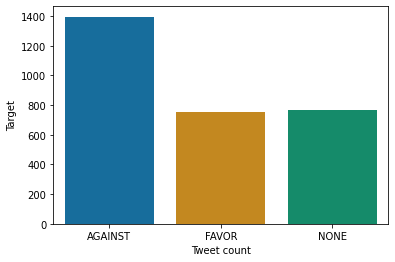

In [12]:
# Plotting distribution of stance across all the target in our training data
gp_df = train_df.groupby('Stance')['Tweet'].count().reset_index()
g = sns.barplot(x='Stance', y='Tweet', data=gp_df, palette='colorblind')
g.set(xlabel='Tweet count', ylabel='Target')
plt.show()

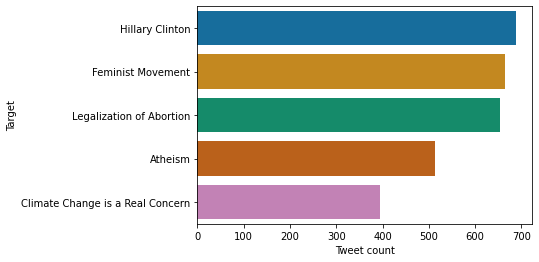

In [13]:
# Plotting Distribution of individual target tweets in our training data
gp_df = train_df['Target'].value_counts().reset_index()
g = sns.barplot(x='Target', y='index', data=gp_df, palette='colorblind')
g.set(xlabel='Tweet count', ylabel='Target')
plt.show()

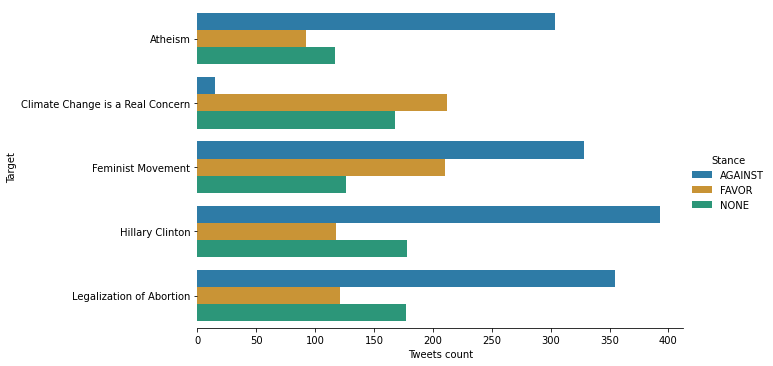

In [14]:
# Plotting distribution of stance for individual target in training data
gp_df = train_df.groupby(['Target','Stance'])['Tweet'].count().reset_index()
g = sns.catplot(data=gp_df, kind="bar",x="Tweet", y="Target", hue="Stance",\
                ci="sd", palette="colorblind", alpha=.9, height=5, aspect=11.7/6 )
g.despine(left=True)
g.set_axis_labels("Tweets count", "Target")
plt.show()

In [15]:
# Instantiate EDA class object to perform some detailed exploration of our training dara
tweets_eda = EDA()
tweets_eda.data = train_df

# Caculation meta features (word_count, unique word count etc.) for tweets in training data
tweets_eda.calculate_meta_features()

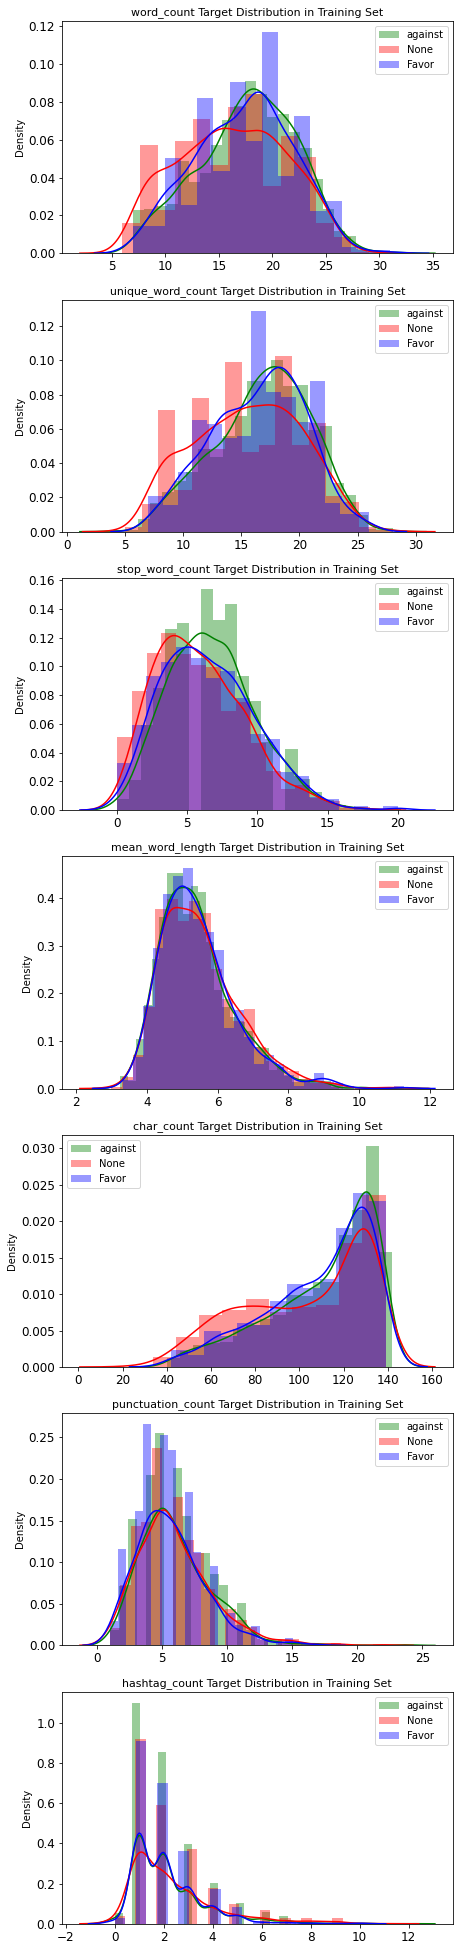

In [16]:
# Plotting our metafeatures for stance across all the target in our training data
tweets_eda.plot_all_metafeatures()

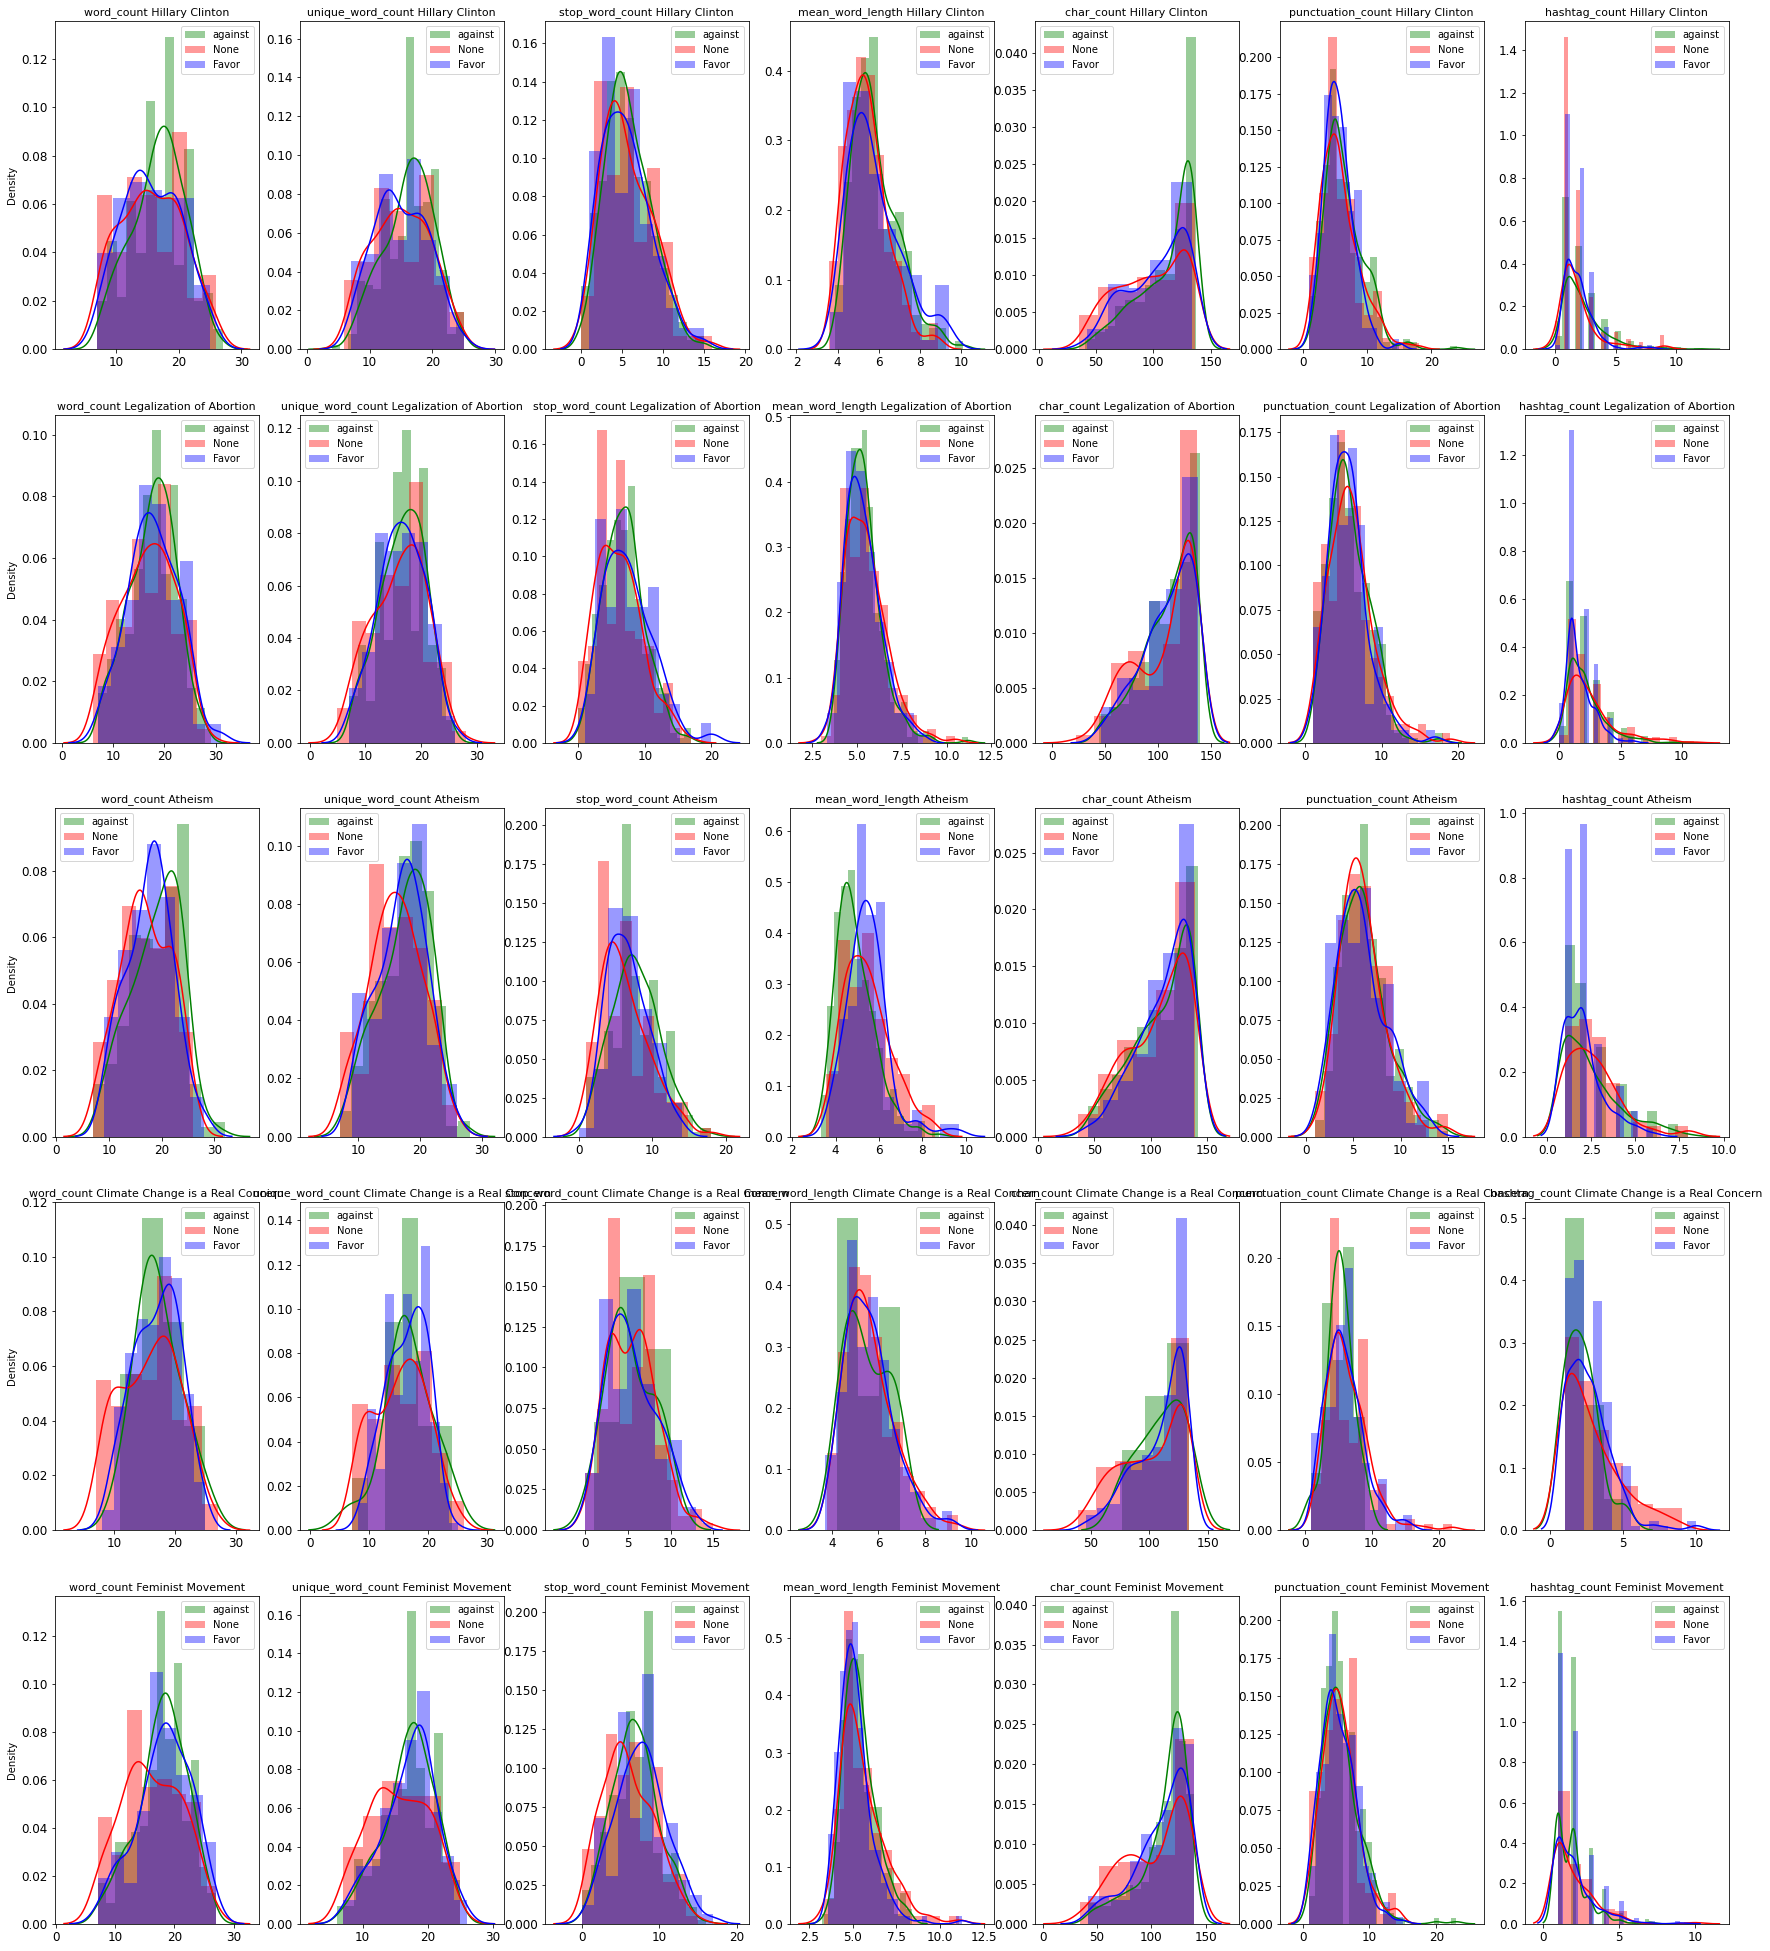

In [17]:
# Plotting our metafeatures across for individual target in our training data
tweets_eda.plot_individual_metafeatures()

#### Plotting Top 100 common words in our training tweets using bar chart across for all target

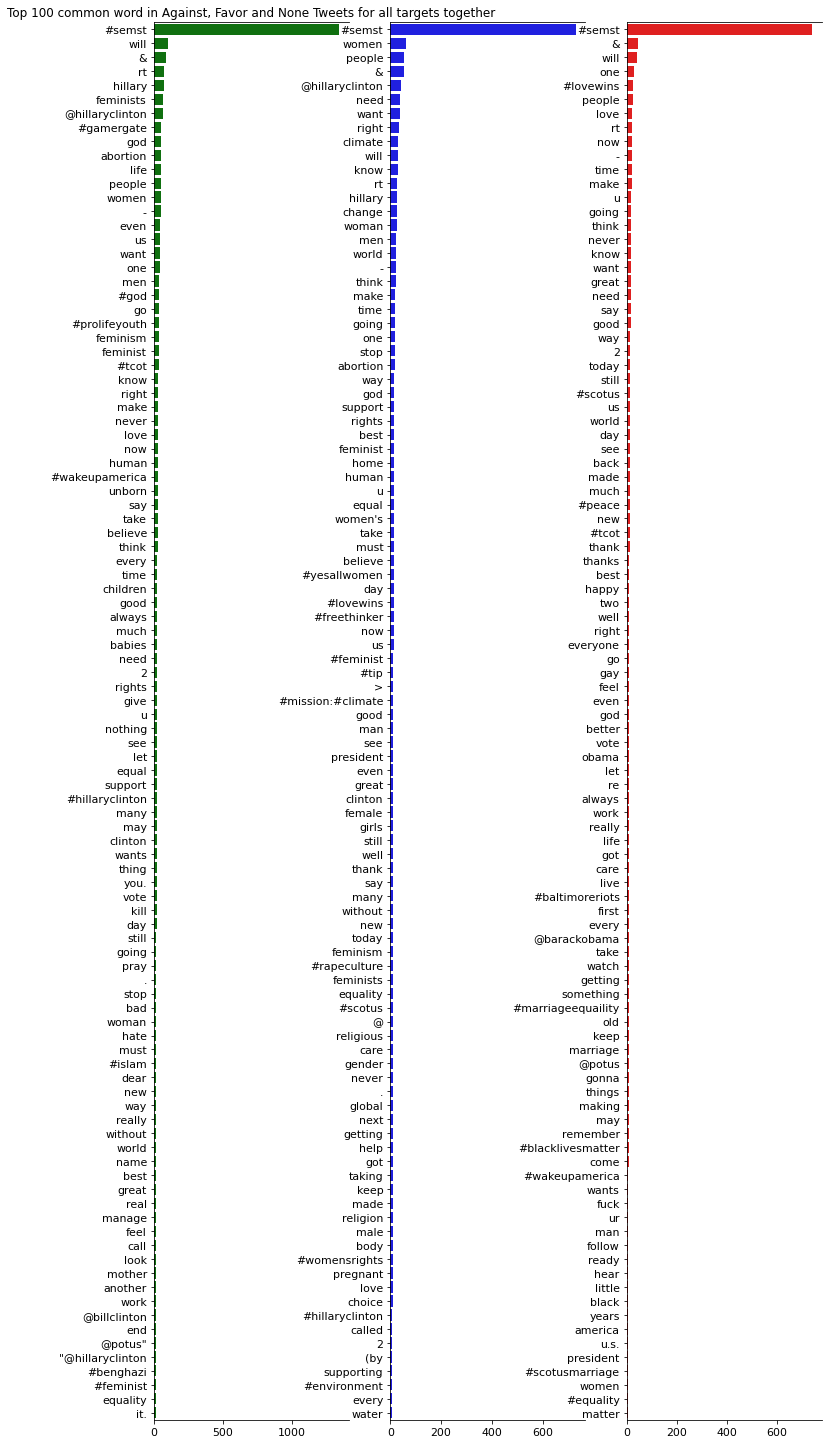

In [18]:
tweets_eda.plot_ngrams()

#### Plotting word cloud for individual target for all stance

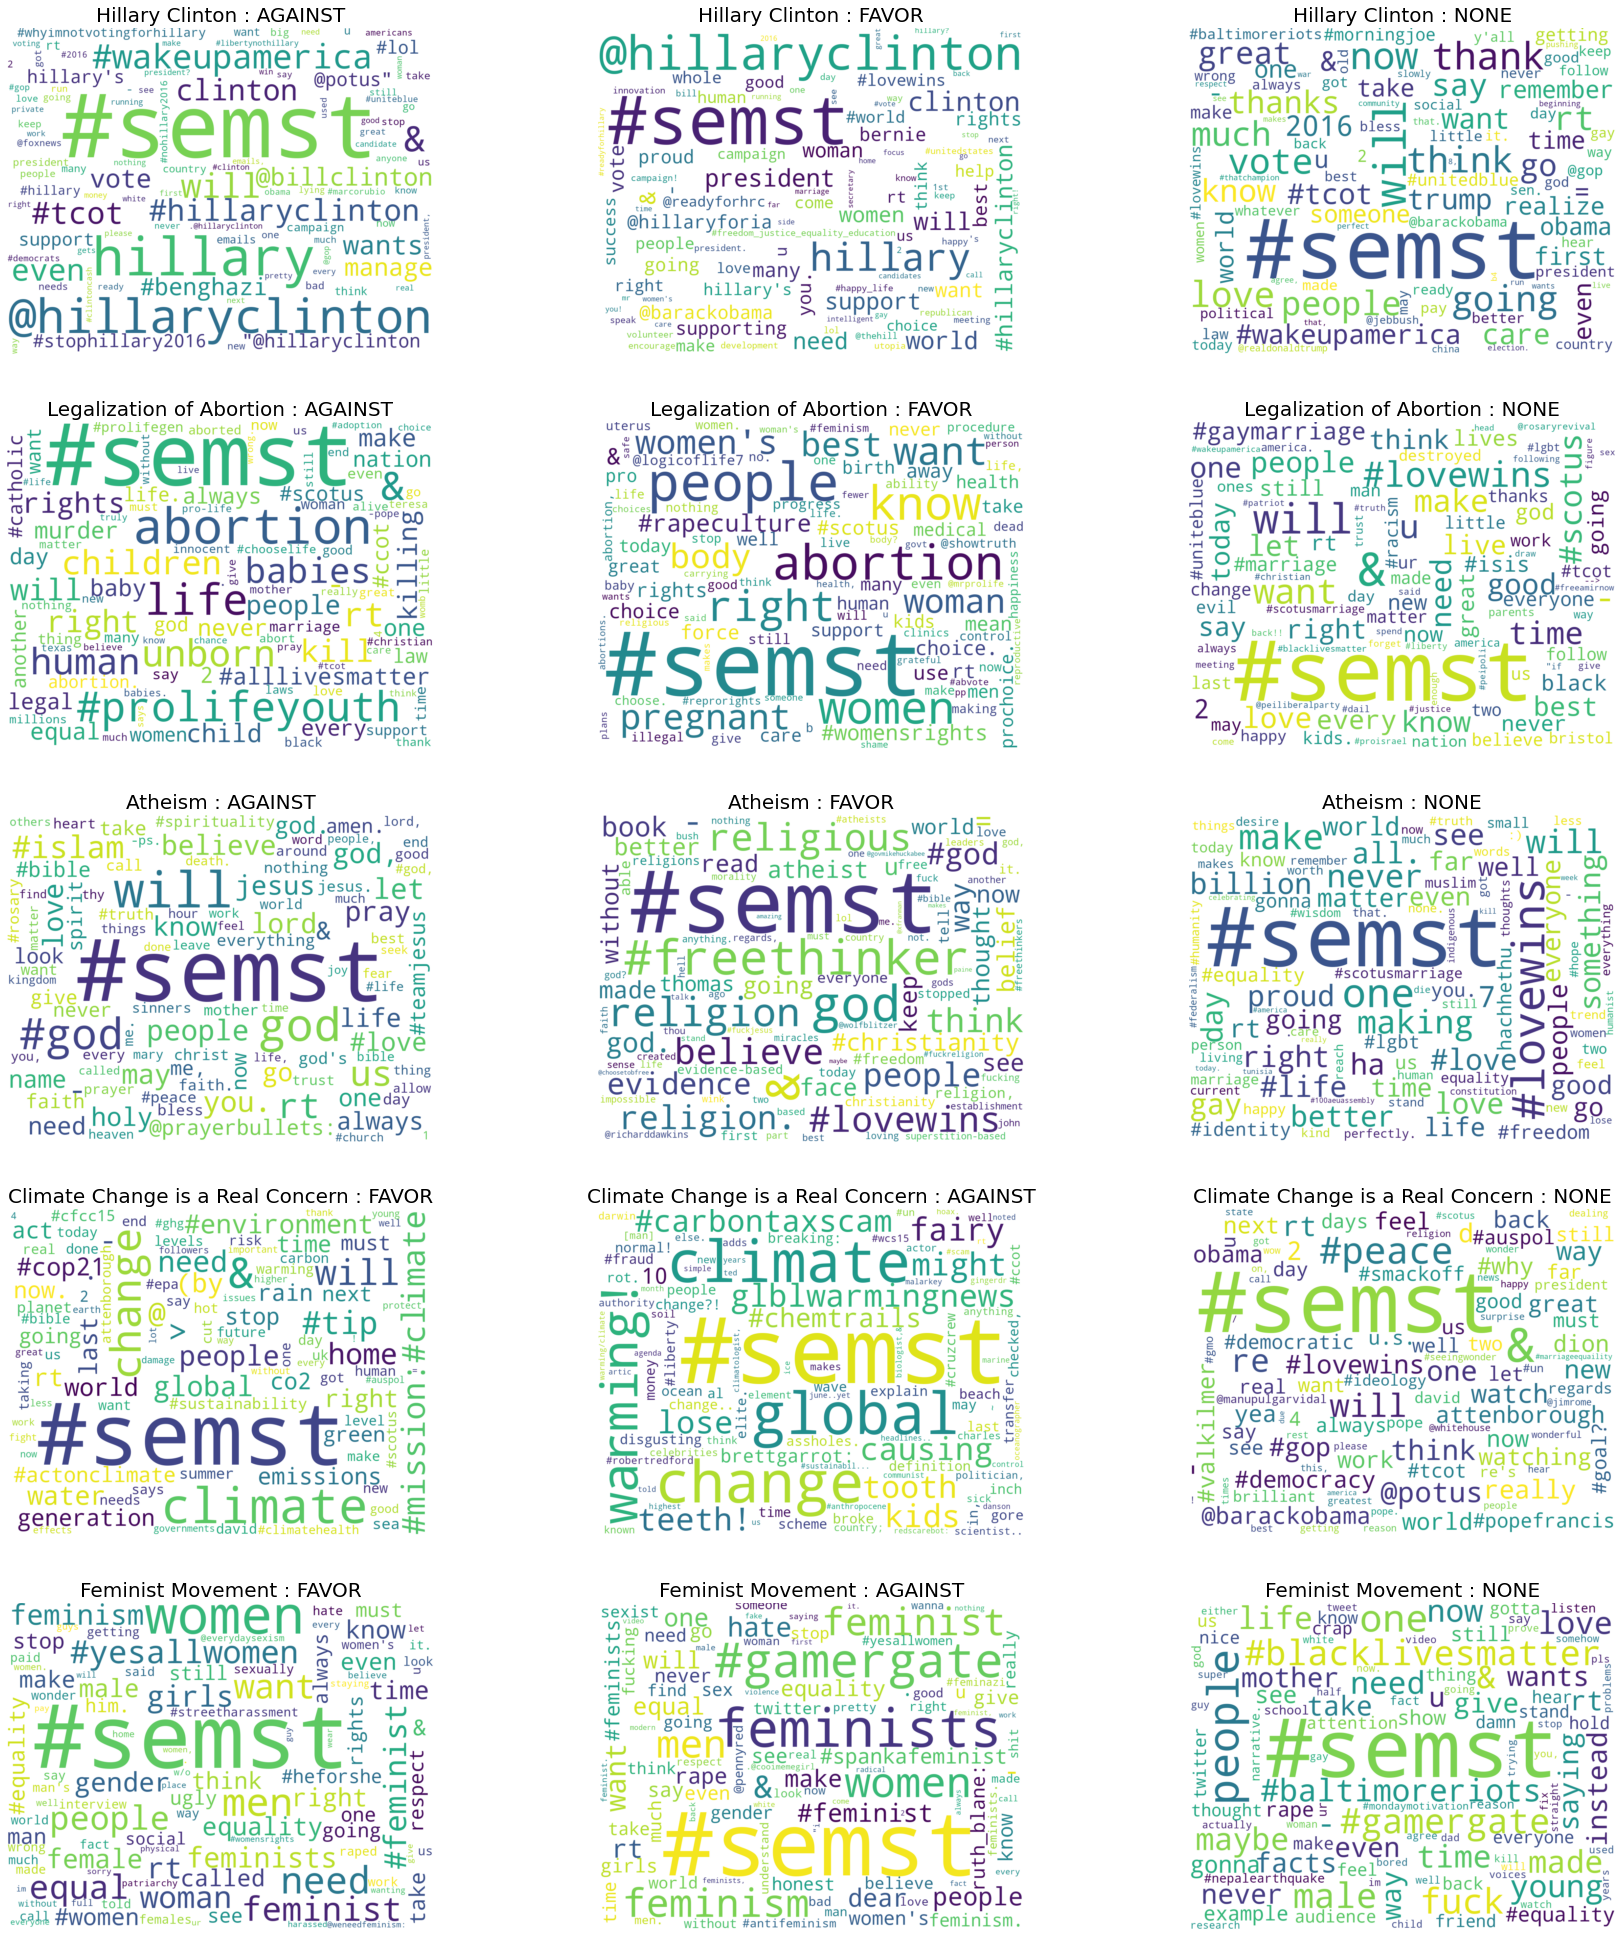

In [19]:
tweets_eda.plot_word_cloud()

## Test PreProcessing

In [20]:
# Instantiating TextPreProcesisng class object 
clean_text = TextPreProcessing()

In [21]:
# Printing raw tweets
train_df['Tweet']

0                 @tedcruz And, #HandOverTheServer she wiped clean + 30k deleted emails, explains dereliction of duty/lies re #Benghazi,etc #tcot
1                                                       Hillary is our best choice if we truly want to continue being a progressive nation. #Ohio
2                                                               @TheView I think our country is ready for a female pres, it can't ever be Hillary
3                    I just gave an unhealthy amount of my hard-earned money away to the big gov't & untrustworthy IRS. #WhyImNotVotingForHillary
4                                                                                            @PortiaABoulger Thank you for adding me to your list
                                                                          ...                                                                    
2909          There's a law protecting unborn eagles, but not  humans uh, idk if you've noticed, but there aren't 7 billion 

#### Performing text Preprocessing on tweets based on our thorough EDA, which highlighted that tweets has quite a few contraction and abberviation in them. Please refer to Text PreProcessing class on top of notebook for details.

In [22]:
# Applying preprocessin on tweets in our training data
train_df['Tweet'] = train_df['Tweet'].apply(str).apply(lambda x: clean_text.all_preprocessing(x))

In [23]:
# Printing tweets after pre processing
train_df['Tweet']

0                          and , # handover the server she wiped clean + 30k deleted emails , explains dereliction of duty / lies re # benghazi , etc # t cot
1                                                                 hillary is our best choice if we truly want to continue being a progressive nation . # ohio
2                                                                                  i think our country is ready for a female pres , it Cannot ever be hillary
3                i just gave an unhealthy amount of my hard - earned money away to the big government and untrustworthy irs . # why im not voting for hillary
4                                                                                                                        thank you for adding me to your list
                                                                                ...                                                                          
2909                      there is a law protecting 

### Preparing our training data for all individual targets

In [24]:
# Creating dataframe for individual target
hc_df = train_df[train_df['Target'] == 'Hillary Clinton']
aa_df = train_df[train_df['Target'] == 'Atheism']
la_df = train_df[train_df['Target'] == 'Legalization of Abortion']
fm_df = train_df[train_df['Target'] == 'Feminist Movement']
cc_df = train_df[train_df['Target'] == 'Climate Change is a Real Concern']

#### Creating 5 stratified folds for evaluating our performance model and for hyper paramter tuning

In [25]:
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 0)

#### Importing BERT Large Uncased Model from tensorflow hub

In [26]:
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_wwm_uncased_L-24_H-1024_A-16/2", trainable=False)

#### Initializing BERT vocabulary and tokenizer

In [27]:
BertTokenizer = bert.bert_tokenization.FullTokenizer
vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy() 
tokenizer = BertTokenizer(vocabulary_file, bert_layer.resolved_object.do_lower_case.numpy())

#### Plotting word count for individual target and across all the target because so we can choose a constant length for padding

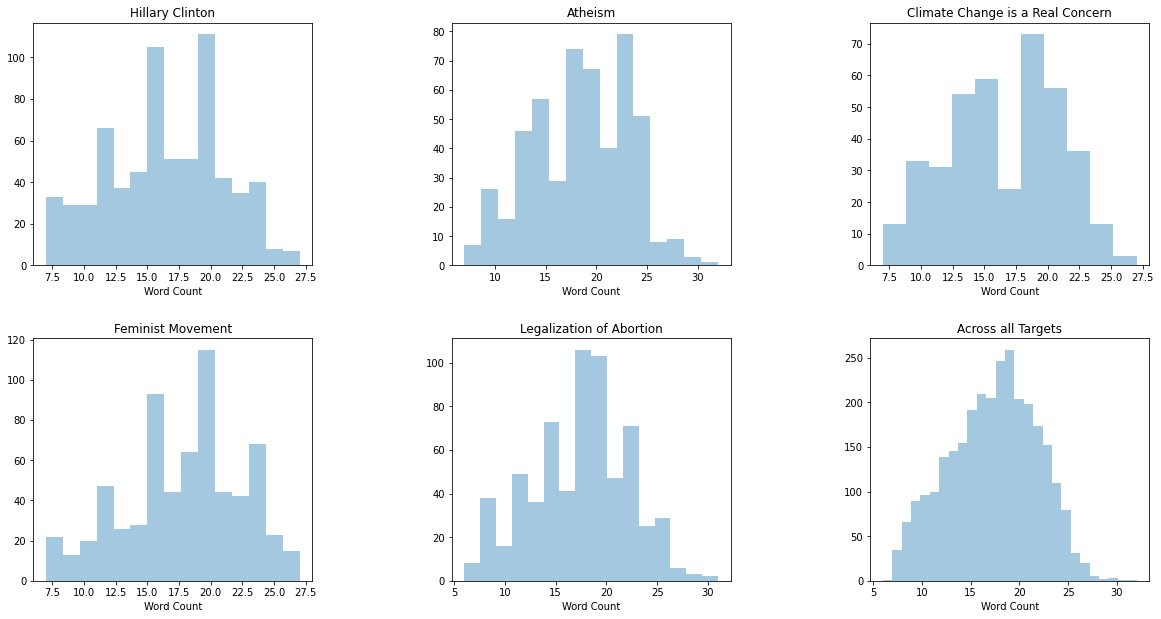

In [28]:
plot_word_count()

#### This function add special token [CLS] at the start and [SEP] token at the end of tweets. After that all the tweets are padded to a constant length of 35

In [29]:
MAX_SEQ_LEN = 35
CLASSES = train_df['Stance'].nunique()

In [30]:
def bert_tokenizer_and_padding(tweets, tokenizer, max_seq_len = MAX_SEQ_LEN):  
    alltokens = []
    allmasks = []
    allsegments = []
    
    for tweet in tweets:
        tweet = tokenizer.tokenize(tweet)
        tweet = tweet[:max_seq_len - 2]
        tokenize_tweet = ["[CLS]"] + tweet + ["[SEP]"]
    
        padding_length = max_seq_len - len(tokenize_tweet)
        
        tokens = tokenizer.convert_tokens_to_ids(tokenize_tweet) 
        tokens = tokens + [0] * padding_length 
       
        pad_masks = [1] * len(tokenize_tweet) + [0] * padding_length 
        segment_ids = [0] * max_seq_len
        
        alltokens.append(tokens) 
        allmasks.append(pad_masks) 
        allsegments.append(segment_ids)
        
    alltokens = np.array(alltokens)
    allmasks = np.array(allmasks)
    allsegments = np.array(allsegments)
    
    return alltokens, allmasks, allsegments 

#### Creating model which consist of 2 fully connected layer and a output layer

In [31]:
def build_model(bert_layer, max_len = MAX_SEQ_LEN):
    
    input_word_ids = keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :] 
    
    hidden_layer_1 = keras.layers.Dense(256, activation='relu')(clf_output)
    hidden_layer_1 = keras.layers.Dropout(0.5)(hidden_layer_1)
    hidden_layer_2 = keras.layers.Dense(128, activation='relu')(hidden_layer_1)
    hidden_layer_2 = keras.layers.Dropout(0.5)(hidden_layer_2)

    output_layer = keras.layers.Dense(CLASSES, activation='softmax')(hidden_layer_2) 
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs = output_layer)
    model.compile(keras.optimizers.Adam(lr = 2e-5), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model

In [32]:
model = build_model(bert_layer)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 35)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 35)]         0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

#### Using stratified cross validation and loss curve for hyperparameter tuning

In [33]:
def train_model(target, X, y, batch_size, learning_rate):  
  
  validation_score = []
  fold_count = 0
    
  # Stratified k fold cross validation for hyper paramter tuning 
  cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 0)
  
  for train_index, val_index in cv.split(X, y):
    
    # Using 4 folds for training and one fold for validaiton
    train_x, val_x = X.iloc[train_index], X.iloc[val_index]
    train_y, val_y = y[train_index], y[val_index]
    
    # Performing Bert tokenization and then padding to train and validatio tweets
    train_x = bert_tokenizer_and_padding(train_x, tokenizer)
    val_x = bert_tokenizer_and_padding(val_x, tokenizer)
    
    # Converting our label encoded class vector to binary class vector
    y_class = train_y
    train_y = to_categorical(train_y, dtype ="uint8")
    val_y = to_categorical(val_y, dtype ="uint8")

    # Building our model
    model = build_model(bert_layer)
    
    # Configuring our model for training by using Adam optimizer and categorical crossentropy loss
    model.compile(keras.optimizers.Adam(lr = learning_rate), loss = 'categorical_crossentropy', metrics = ['accuracy'])

    print(f'<-------- Fold : {fold_count} for  target : {target} -------->')
    
    # Using EarlyStopping to stop and restore to best weight if model validaiton loss does not improve straight for 5 epochs
    early_stopping_call = EarlyStopping(monitor = 'val_loss', patience = 5, mode = 'min', min_delta = 0.001, restore_best_weights = True)
    
    #Estimating our class weight for imbalance classes
    class_weights = class_weight.compute_class_weight('balanced', np.unique(y_class), y_class)
    class_weight_dict = dict(enumerate(class_weights))
    
    # Training our Model
    history = model.fit(
      x = train_x, 
      y = train_y,
      batch_size = 32,
      class_weight = class_weight_dict,
      epochs = 50,
      validation_data = (val_x, val_y),
      callbacks = [early_stopping_call])

    _, train_acc = model.evaluate(train_x, train_y)
    _, val_acc = model.evaluate(val_x,val_y)
    
    print ('-'*50)
    print(f'Training accuaray for fold {fold_count} : ', train_acc)
    print(f'Validation accuracy for fold {fold_count} : ', val_acc)
    print ('-'*50)
    print ()

    scores = model.evaluate(val_x, val_y, verbose = 0)
    validation_score.append(scores[1] * 100)
    fold_count = fold_count + 1
    plot_loss_curve(history)
    
    del history
    del model
    import gc
    gc.collect()
    
  print ('-'*50)  
  print("Average accuracy across all 5 folds : %.2f%% (+/- %.2f%%)" % (np.mean(validation_score), np.std(validation_score)))
  return model, history

In [34]:
def train_model_without_cv(target, X, y, batch_size, learning_rate, epochs):  
  
    # Performing Bert tokenization and then padding to train and validatio tweets
    train_x = bert_tokenizer_and_padding(X, tokenizer)
    
    # Converting our label encoded class vector to binary class vector
    y_class = y
    train_y = to_categorical(y, dtype ="uint8")
    model = None
    # Building our model
    model = build_model(bert_layer)
    
    # Configuring our model for training by using Adam optimizer and categorical crossentropy loss
    model.compile(keras.optimizers.Adam(lr = learning_rate), loss = 'categorical_crossentropy', metrics = ['accuracy'])

    #Estimating our class weight for imbalance classes
    class_weights = class_weight.compute_class_weight('balanced', np.unique(y_class), y_class)
    class_weight_dict = dict(enumerate(class_weights))
    
    # Using Model checkpoint to save best weight for our Model
    # model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    # filepath=model_paths + target +'.h5',
    # monitor='loss',
    # mode='min',
    # save_best_only=True)

    # Using EarlyStopping to stop and restore to best weight if model validaiton loss does not improve straight for 5 epochs
    early_stopping_call = keras.callbacks.EarlyStopping(monitor = 'loss', patience = 5, mode = 'min', min_delta = 0.001, restore_best_weights = True)

    hsitory = None
    # Training our Model
    history = model.fit(
      x = train_x, 
      y = train_y,
      batch_size = batch_size,
      class_weight = class_weight_dict,
      epochs = epochs,
      callbacks = [early_stopping_call])
    
    return model, history

In [35]:
#Fitting Label encoder on whole train data
le = fit_label_encoder(train_df)

<-------- Fold : 0 for  target : Atheism -------->
Epoch 1/50
13/13 [==============================] - 8s 645ms/step - loss: 1.2841 - accuracy: 0.3756 - val_loss: 1.0059 - val_accuracy: 0.5631
Epoch 2/50
13/13 [==============================] - 6s 452ms/step - loss: 1.1340 - accuracy: 0.3878 - val_loss: 1.0516 - val_accuracy: 0.4563
Epoch 3/50
13/13 [==============================] - 6s 450ms/step - loss: 1.1612 - accuracy: 0.3171 - val_loss: 1.0274 - val_accuracy: 0.5728
Epoch 4/50
13/13 [==============================] - 6s 452ms/step - loss: 1.1493 - accuracy: 0.3756 - val_loss: 1.0709 - val_accuracy: 0.3981
Epoch 5/50
13/13 [==============================] - 6s 450ms/step - loss: 1.1196 - accuracy: 0.3634 - val_loss: 1.0268 - val_accuracy: 0.5340
Epoch 6/50
13/13 [==============================] - 7s 559ms/step - loss: 1.0630 - accuracy: 0.4366 - val_loss: 0.8955 - val_accuracy: 0.6796
Epoch 7/50
13/13 [==============================] - 7s 508ms/step - loss: 0.9531 - accuracy: 0.57

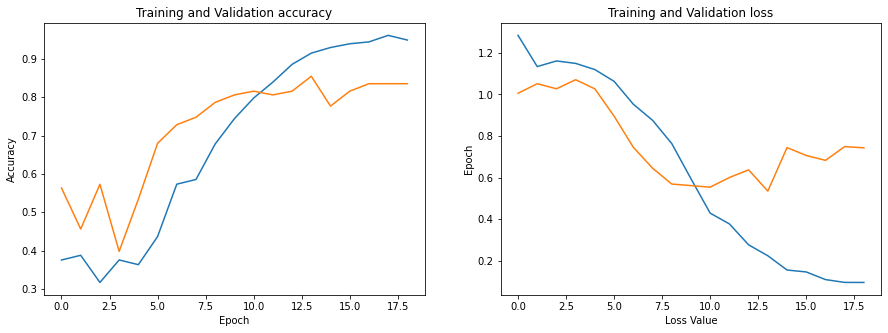

<-------- Fold : 1 for  target : Atheism -------->
Epoch 1/50
13/13 [==============================] - 8s 653ms/step - loss: 1.0073 - accuracy: 0.5220 - val_loss: 0.3593 - val_accuracy: 0.8738
Epoch 2/50
13/13 [==============================] - 7s 514ms/step - loss: 0.4680 - accuracy: 0.8171 - val_loss: 0.3379 - val_accuracy: 0.8835
Epoch 3/50
13/13 [==============================] - 7s 502ms/step - loss: 0.2936 - accuracy: 0.8829 - val_loss: 0.3024 - val_accuracy: 0.9029
Epoch 4/50
13/13 [==============================] - 6s 451ms/step - loss: 0.2345 - accuracy: 0.9024 - val_loss: 0.4808 - val_accuracy: 0.8350
Epoch 5/50
13/13 [==============================] - 7s 501ms/step - loss: 0.1715 - accuracy: 0.9341 - val_loss: 0.2855 - val_accuracy: 0.9126
Epoch 6/50
13/13 [==============================] - 6s 451ms/step - loss: 0.1008 - accuracy: 0.9610 - val_loss: 0.3324 - val_accuracy: 0.9126
Epoch 7/50
13/13 [==============================] - 6s 450ms/step - loss: 0.1061 - accuracy: 0.96

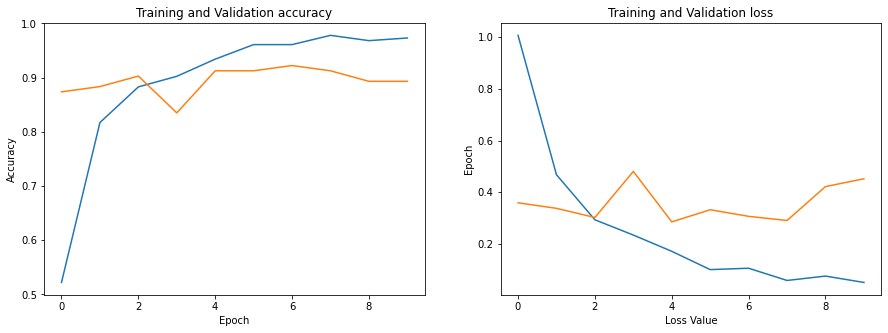

<-------- Fold : 2 for  target : Atheism -------->
Epoch 1/50
13/13 [==============================] - 8s 630ms/step - loss: 0.7709 - accuracy: 0.6829 - val_loss: 0.1583 - val_accuracy: 0.9417
Epoch 2/50
13/13 [==============================] - 7s 505ms/step - loss: 0.3125 - accuracy: 0.8927 - val_loss: 0.1313 - val_accuracy: 0.9515
Epoch 3/50
13/13 [==============================] - 7s 508ms/step - loss: 0.1917 - accuracy: 0.9293 - val_loss: 0.0847 - val_accuracy: 0.9709
Epoch 4/50
13/13 [==============================] - 7s 503ms/step - loss: 0.1211 - accuracy: 0.9512 - val_loss: 0.0668 - val_accuracy: 0.9806
Epoch 5/50
13/13 [==============================] - 6s 452ms/step - loss: 0.1026 - accuracy: 0.9659 - val_loss: 0.2480 - val_accuracy: 0.9417
Epoch 6/50
13/13 [==============================] - 6s 454ms/step - loss: 0.1275 - accuracy: 0.9561 - val_loss: 0.2890 - val_accuracy: 0.9320
Epoch 7/50
13/13 [==============================] - 6s 450ms/step - loss: 0.0953 - accuracy: 0.97

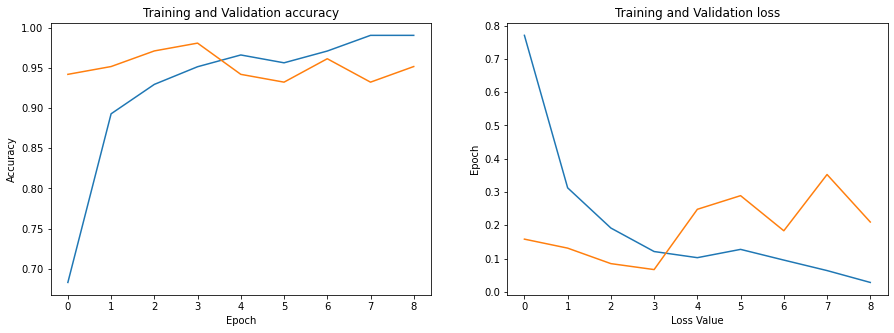

<-------- Fold : 3 for  target : Atheism -------->
Epoch 1/50
13/13 [==============================] - 8s 610ms/step - loss: 0.7161 - accuracy: 0.7348 - val_loss: 0.0350 - val_accuracy: 1.0000
Epoch 2/50
13/13 [==============================] - 7s 518ms/step - loss: 0.2728 - accuracy: 0.8954 - val_loss: 0.0235 - val_accuracy: 0.9902
Epoch 3/50
13/13 [==============================] - 6s 452ms/step - loss: 0.2360 - accuracy: 0.9197 - val_loss: 0.0312 - val_accuracy: 0.9902
Epoch 4/50
13/13 [==============================] - 6s 451ms/step - loss: 0.1116 - accuracy: 0.9659 - val_loss: 0.0237 - val_accuracy: 0.9902
Epoch 5/50
13/13 [==============================] - 6s 452ms/step - loss: 0.0947 - accuracy: 0.9805 - val_loss: 0.0772 - val_accuracy: 0.9902
Epoch 6/50
13/13 [==============================] - 6s 450ms/step - loss: 0.0819 - accuracy: 0.9757 - val_loss: 0.0616 - val_accuracy: 0.9902
Epoch 7/50
4/4 [==============================] - 0s 86ms/step - loss: 0.0235 - accuracy: 0.9902


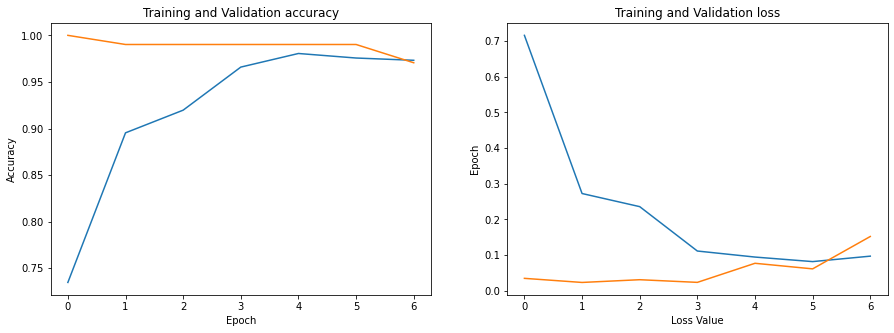

<-------- Fold : 4 for  target : Atheism -------->
Epoch 1/50
13/13 [==============================] - 8s 639ms/step - loss: 0.5689 - accuracy: 0.7883 - val_loss: 0.0832 - val_accuracy: 0.9804
Epoch 2/50
13/13 [==============================] - 6s 461ms/step - loss: 0.1901 - accuracy: 0.9416 - val_loss: 0.1369 - val_accuracy: 0.9706
Epoch 3/50
13/13 [==============================] - 6s 452ms/step - loss: 0.0911 - accuracy: 0.9684 - val_loss: 0.1839 - val_accuracy: 0.9510
Epoch 4/50
13/13 [==============================] - 6s 451ms/step - loss: 0.1347 - accuracy: 0.9538 - val_loss: 0.1182 - val_accuracy: 0.9706
Epoch 5/50
13/13 [==============================] - 6s 451ms/step - loss: 0.0913 - accuracy: 0.9732 - val_loss: 0.1332 - val_accuracy: 0.9804
Epoch 6/50
4/4 [==============================] - 0s 90ms/step - loss: 0.0832 - accuracy: 0.9804
--------------------------------------------------
Training accuaray for fold 4 :  0.9805352687835693
Validation accuracy for fold 4 :  0.9803

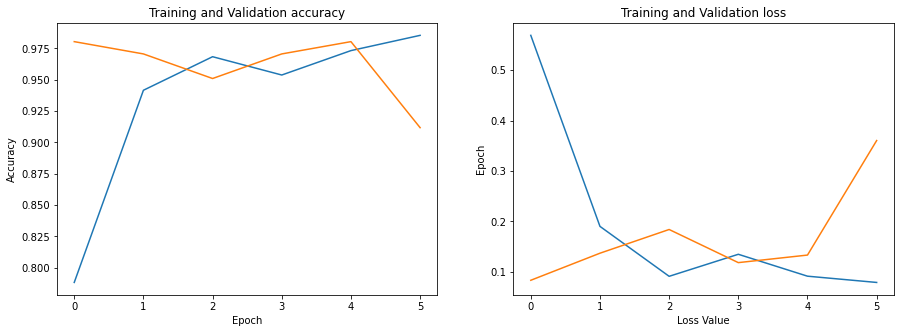

--------------------------------------------------
Average accuracy across all 5 folds : 94.36% (+/- 5.26%)


In [36]:
y = encode_labels(aa_df['Stance'], le)
train_model(aa_df['Target'].unique()[0], aa_df['Tweet'], y, batch_size = 32, learning_rate = 2e-5)

### Training Model for Target "Feminist Movement" 

<-------- Fold : 0 for  target : Feminist Movement -------->
Epoch 1/50
17/17 [==============================] - 10s 597ms/step - loss: 1.4157 - accuracy: 0.3446 - val_loss: 1.0644 - val_accuracy: 0.3534
Epoch 2/50
17/17 [==============================] - 9s 523ms/step - loss: 1.3118 - accuracy: 0.3390 - val_loss: 1.0457 - val_accuracy: 0.4586
Epoch 3/50
17/17 [==============================] - 8s 496ms/step - loss: 1.1944 - accuracy: 0.3691 - val_loss: 1.0426 - val_accuracy: 0.4737
Epoch 4/50
17/17 [==============================] - 8s 496ms/step - loss: 1.2385 - accuracy: 0.3823 - val_loss: 1.0273 - val_accuracy: 0.5338
Epoch 5/50
17/17 [==============================] - 8s 492ms/step - loss: 1.1582 - accuracy: 0.4030 - val_loss: 1.0124 - val_accuracy: 0.5113
Epoch 6/50
17/17 [==============================] - 8s 496ms/step - loss: 1.1317 - accuracy: 0.3898 - val_loss: 0.9980 - val_accuracy: 0.5789
Epoch 7/50
17/17 [==============================] - 8s 492ms/step - loss: 1.1147 - acc

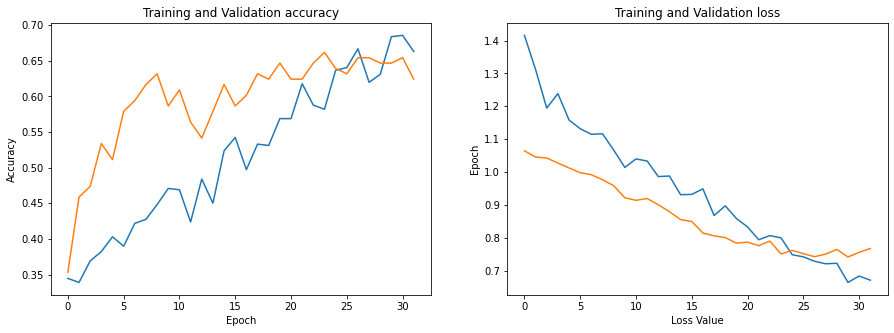

<-------- Fold : 1 for  target : Feminist Movement -------->
Epoch 1/50
17/17 [==============================] - 10s 566ms/step - loss: 1.2682 - accuracy: 0.3861 - val_loss: 0.9309 - val_accuracy: 0.5564
Epoch 2/50
17/17 [==============================] - 8s 499ms/step - loss: 1.2613 - accuracy: 0.3729 - val_loss: 0.8925 - val_accuracy: 0.6015
Epoch 3/50
17/17 [==============================] - 8s 492ms/step - loss: 1.1065 - accuracy: 0.4011 - val_loss: 0.8528 - val_accuracy: 0.6165
Epoch 4/50
17/17 [==============================] - 8s 493ms/step - loss: 0.9993 - accuracy: 0.5066 - val_loss: 0.8133 - val_accuracy: 0.6241
Epoch 5/50
17/17 [==============================] - 8s 492ms/step - loss: 0.9692 - accuracy: 0.4972 - val_loss: 0.8099 - val_accuracy: 0.6165
Epoch 6/50
17/17 [==============================] - 8s 499ms/step - loss: 1.0338 - accuracy: 0.4878 - val_loss: 0.8005 - val_accuracy: 0.6090
Epoch 7/50
17/17 [==============================] - 8s 498ms/step - loss: 0.9425 - acc

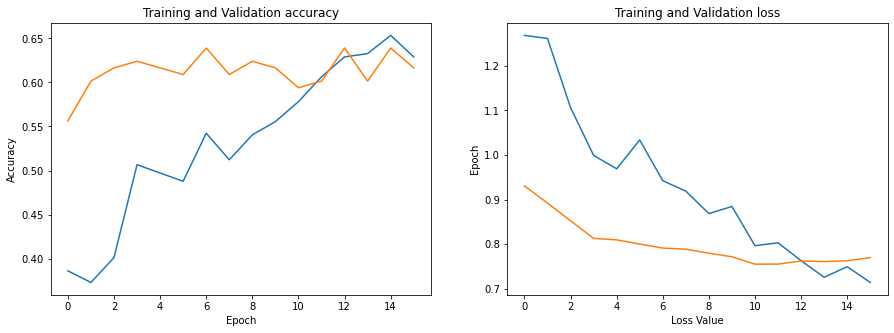

<-------- Fold : 2 for  target : Feminist Movement -------->
Epoch 1/50
17/17 [==============================] - 10s 589ms/step - loss: 1.3701 - accuracy: 0.3503 - val_loss: 0.9343 - val_accuracy: 0.5414
Epoch 2/50
17/17 [==============================] - 9s 506ms/step - loss: 1.1382 - accuracy: 0.4237 - val_loss: 0.8265 - val_accuracy: 0.5940
Epoch 3/50
17/17 [==============================] - 8s 492ms/step - loss: 1.0543 - accuracy: 0.4595 - val_loss: 0.7795 - val_accuracy: 0.6541
Epoch 4/50
17/17 [==============================] - 8s 493ms/step - loss: 0.9805 - accuracy: 0.4896 - val_loss: 0.7336 - val_accuracy: 0.6992
Epoch 5/50
17/17 [==============================] - 8s 454ms/step - loss: 0.9296 - accuracy: 0.5254 - val_loss: 0.7356 - val_accuracy: 0.6692
Epoch 6/50
17/17 [==============================] - 8s 494ms/step - loss: 0.8793 - accuracy: 0.5499 - val_loss: 0.6885 - val_accuracy: 0.6917
Epoch 7/50
17/17 [==============================] - 8s 491ms/step - loss: 0.8263 - acc

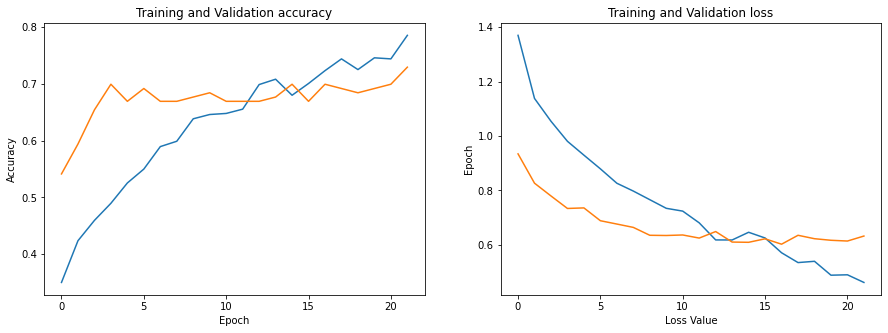

<-------- Fold : 3 for  target : Feminist Movement -------->
Epoch 1/50
17/17 [==============================] - 10s 567ms/step - loss: 1.3272 - accuracy: 0.4313 - val_loss: 0.7526 - val_accuracy: 0.7143
Epoch 2/50
17/17 [==============================] - 9s 502ms/step - loss: 1.0801 - accuracy: 0.5009 - val_loss: 0.6339 - val_accuracy: 0.7970
Epoch 3/50
17/17 [==============================] - 8s 495ms/step - loss: 0.9040 - accuracy: 0.5631 - val_loss: 0.5656 - val_accuracy: 0.7820
Epoch 4/50
17/17 [==============================] - 8s 492ms/step - loss: 0.8351 - accuracy: 0.5913 - val_loss: 0.5471 - val_accuracy: 0.7669
Epoch 5/50
17/17 [==============================] - 9s 503ms/step - loss: 0.7356 - accuracy: 0.6252 - val_loss: 0.4989 - val_accuracy: 0.7744
Epoch 6/50
17/17 [==============================] - 8s 493ms/step - loss: 0.7504 - accuracy: 0.6610 - val_loss: 0.4679 - val_accuracy: 0.7820
Epoch 7/50
17/17 [==============================] - 8s 455ms/step - loss: 0.6582 - acc

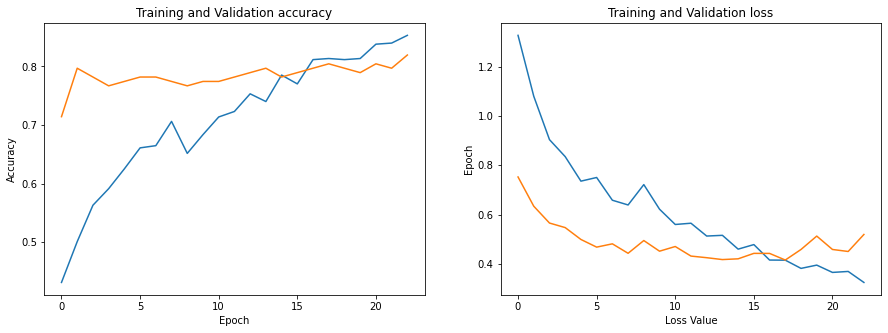

<-------- Fold : 4 for  target : Feminist Movement -------->
Epoch 1/50
17/17 [==============================] - 10s 609ms/step - loss: 1.1340 - accuracy: 0.4737 - val_loss: 0.5484 - val_accuracy: 0.8712
Epoch 2/50
17/17 [==============================] - 9s 504ms/step - loss: 0.8580 - accuracy: 0.5940 - val_loss: 0.3971 - val_accuracy: 0.8939
Epoch 3/50
17/17 [==============================] - 8s 494ms/step - loss: 0.7290 - accuracy: 0.6429 - val_loss: 0.3287 - val_accuracy: 0.9091
Epoch 4/50
17/17 [==============================] - 9s 502ms/step - loss: 0.6356 - accuracy: 0.7105 - val_loss: 0.2880 - val_accuracy: 0.9015
Epoch 5/50
17/17 [==============================] - 8s 497ms/step - loss: 0.5475 - accuracy: 0.7406 - val_loss: 0.2825 - val_accuracy: 0.8788
Epoch 6/50
17/17 [==============================] - 8s 492ms/step - loss: 0.5551 - accuracy: 0.7444 - val_loss: 0.2259 - val_accuracy: 0.9394
Epoch 7/50
17/17 [==============================] - 9s 510ms/step - loss: 0.5501 - acc

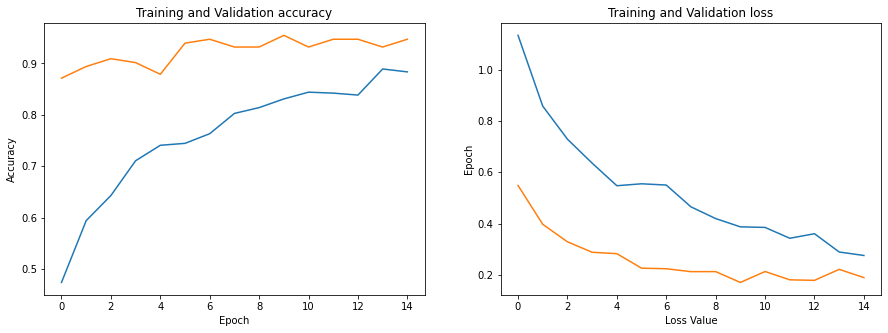

--------------------------------------------------
Average accuracy across all 5 folds : 74.13% (+/- 12.69%)


In [34]:
y = encode_labels(fm_df['Stance'], le)
train_model(fm_df['Target'].unique()[0], fm_df['Tweet'], y, batch_size = 32, learning_rate = 2e-6)

### Training Model for Target "Climate Change is a Real Concern"

<-------- Fold : 0 for  target : Climate Change is a Real Concern -------->
Epoch 1/50
10/10 [==============================] - 7s 706ms/step - loss: 1.4054 - accuracy: 0.2532 - val_loss: 1.1900 - val_accuracy: 0.3291
Epoch 2/50
10/10 [==============================] - 6s 570ms/step - loss: 1.4208 - accuracy: 0.3101 - val_loss: 1.1553 - val_accuracy: 0.2911
Epoch 3/50
10/10 [==============================] - 5s 515ms/step - loss: 1.3315 - accuracy: 0.3101 - val_loss: 1.0014 - val_accuracy: 0.4304
Epoch 4/50
10/10 [==============================] - 4s 442ms/step - loss: 1.4134 - accuracy: 0.3070 - val_loss: 1.2052 - val_accuracy: 0.1013
Epoch 5/50
10/10 [==============================] - 4s 441ms/step - loss: 1.2711 - accuracy: 0.2437 - val_loss: 1.1336 - val_accuracy: 0.2278
Epoch 6/50
10/10 [==============================] - 5s 514ms/step - loss: 1.2131 - accuracy: 0.3196 - val_loss: 0.9811 - val_accuracy: 0.4177
Epoch 7/50
10/10 [==============================] - 4s 442ms/step - loss

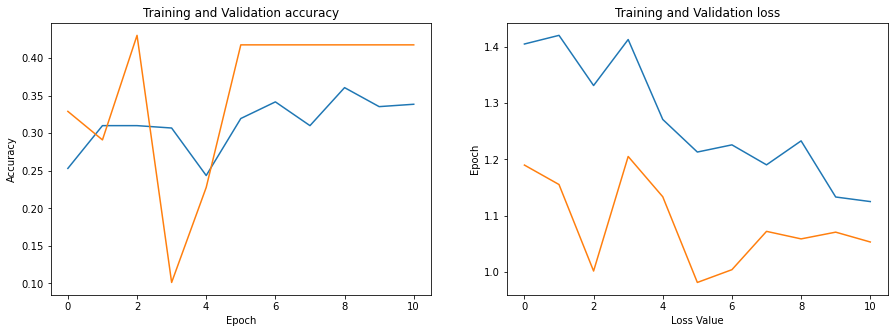

<-------- Fold : 1 for  target : Climate Change is a Real Concern -------->
Epoch 1/50
10/10 [==============================] - 7s 694ms/step - loss: 1.5680 - accuracy: 0.4146 - val_loss: 1.0654 - val_accuracy: 0.5443
Epoch 2/50
10/10 [==============================] - 4s 441ms/step - loss: 1.4314 - accuracy: 0.3576 - val_loss: 1.0925 - val_accuracy: 0.4304
Epoch 3/50
10/10 [==============================] - 4s 443ms/step - loss: 1.1997 - accuracy: 0.3639 - val_loss: 1.1393 - val_accuracy: 0.1519
Epoch 4/50
10/10 [==============================] - 5s 513ms/step - loss: 1.3146 - accuracy: 0.3449 - val_loss: 1.0159 - val_accuracy: 0.6203
Epoch 5/50
10/10 [==============================] - 5s 531ms/step - loss: 1.1590 - accuracy: 0.4430 - val_loss: 1.0010 - val_accuracy: 0.6962
Epoch 6/50
10/10 [==============================] - 4s 443ms/step - loss: 1.1058 - accuracy: 0.4335 - val_loss: 1.1326 - val_accuracy: 0.0759
Epoch 7/50
10/10 [==============================] - 4s 446ms/step - loss

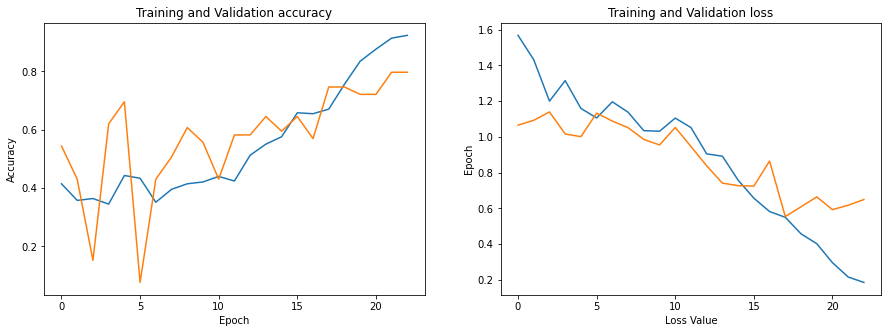

<-------- Fold : 2 for  target : Climate Change is a Real Concern -------->
Epoch 1/50
10/10 [==============================] - 7s 668ms/step - loss: 1.1162 - accuracy: 0.4968 - val_loss: 0.7885 - val_accuracy: 0.5570
Epoch 2/50
10/10 [==============================] - 5s 518ms/step - loss: 0.9467 - accuracy: 0.5791 - val_loss: 0.5279 - val_accuracy: 0.7848
Epoch 3/50
10/10 [==============================] - 4s 443ms/step - loss: 0.8588 - accuracy: 0.6044 - val_loss: 0.5700 - val_accuracy: 0.7722
Epoch 4/50
10/10 [==============================] - 5s 517ms/step - loss: 0.7407 - accuracy: 0.6804 - val_loss: 0.4426 - val_accuracy: 0.8481
Epoch 5/50
10/10 [==============================] - 4s 442ms/step - loss: 0.6431 - accuracy: 0.7278 - val_loss: 0.4970 - val_accuracy: 0.7722
Epoch 6/50
10/10 [==============================] - 5s 511ms/step - loss: 0.3952 - accuracy: 0.8165 - val_loss: 0.4262 - val_accuracy: 0.8228
Epoch 7/50
10/10 [==============================] - 4s 442ms/step - loss

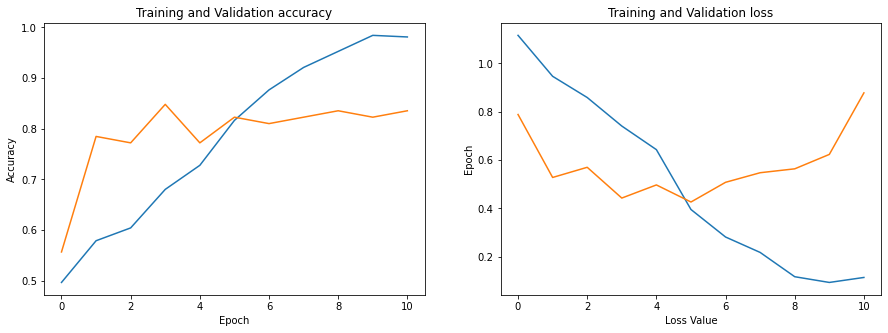

<-------- Fold : 3 for  target : Climate Change is a Real Concern -------->
Epoch 1/50
10/10 [==============================] - 7s 665ms/step - loss: 1.3003 - accuracy: 0.4462 - val_loss: 0.5898 - val_accuracy: 0.7468
Epoch 2/50
10/10 [==============================] - 5s 513ms/step - loss: 0.7511 - accuracy: 0.6741 - val_loss: 0.3389 - val_accuracy: 0.8861
Epoch 3/50
10/10 [==============================] - 5s 519ms/step - loss: 0.4684 - accuracy: 0.7437 - val_loss: 0.2305 - val_accuracy: 0.9367
Epoch 4/50
10/10 [==============================] - 5s 509ms/step - loss: 0.2687 - accuracy: 0.8924 - val_loss: 0.2109 - val_accuracy: 0.9367
Epoch 5/50
10/10 [==============================] - 4s 442ms/step - loss: 0.1924 - accuracy: 0.9209 - val_loss: 0.3568 - val_accuracy: 0.8987
Epoch 6/50
10/10 [==============================] - 4s 444ms/step - loss: 0.1043 - accuracy: 0.9652 - val_loss: 0.2809 - val_accuracy: 0.9241
Epoch 7/50
10/10 [==============================] - 4s 442ms/step - loss

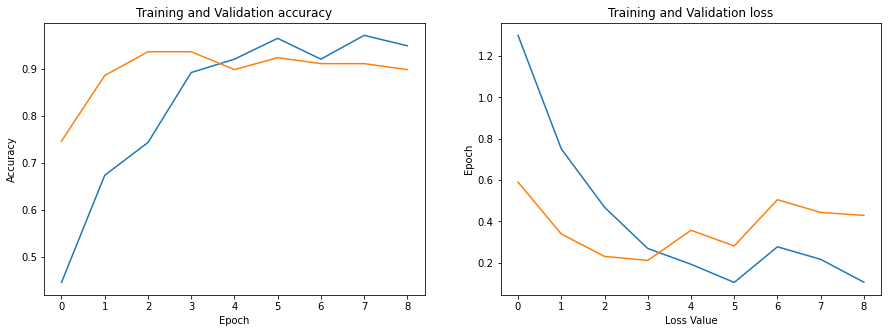

<-------- Fold : 4 for  target : Climate Change is a Real Concern -------->
Epoch 1/50
10/10 [==============================] - 7s 668ms/step - loss: 0.8498 - accuracy: 0.6709 - val_loss: 0.4261 - val_accuracy: 0.8861
Epoch 2/50
10/10 [==============================] - 5s 513ms/step - loss: 0.5833 - accuracy: 0.7975 - val_loss: 0.2138 - val_accuracy: 0.9367
Epoch 3/50
10/10 [==============================] - 5s 520ms/step - loss: 0.3242 - accuracy: 0.8924 - val_loss: 0.1953 - val_accuracy: 0.9367
Epoch 4/50
10/10 [==============================] - 4s 442ms/step - loss: 0.1708 - accuracy: 0.9430 - val_loss: 0.2308 - val_accuracy: 0.9241
Epoch 5/50
10/10 [==============================] - 4s 442ms/step - loss: 0.1190 - accuracy: 0.9462 - val_loss: 0.2808 - val_accuracy: 0.9241
Epoch 6/50
10/10 [==============================] - 5s 510ms/step - loss: 0.1902 - accuracy: 0.9304 - val_loss: 0.0560 - val_accuracy: 0.9873
Epoch 7/50
10/10 [==============================] - 4s 443ms/step - loss

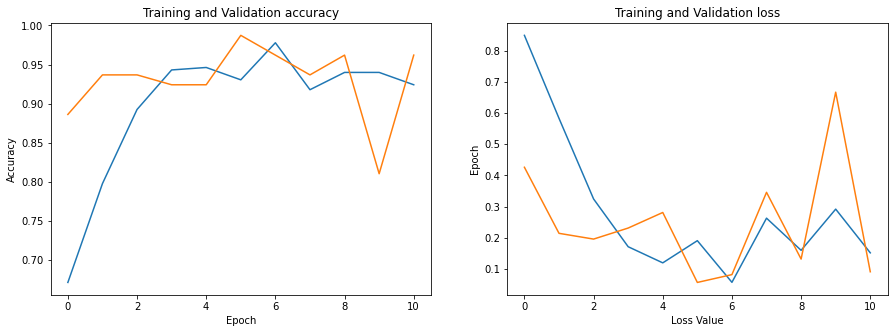

--------------------------------------------------
Average accuracy across all 5 folds : 78.23% (+/- 20.08%)


In [37]:
y = encode_labels(cc_df['Stance'], le)
train_model(cc_df['Target'].unique()[0], cc_df['Tweet'], y, batch_size = 32, learning_rate = 2e-5)

### Training Model for Target "Hillary Clinton"

<-------- Fold : 0 for  target : Hillary Clinton -------->
Epoch 1/50
18/18 [==============================] - 11s 611ms/step - loss: 1.4275 - accuracy: 0.3122 - val_loss: 1.0203 - val_accuracy: 0.5797
Epoch 2/50
18/18 [==============================] - 8s 447ms/step - loss: 1.2158 - accuracy: 0.3466 - val_loss: 1.0828 - val_accuracy: 0.4130
Epoch 3/50
18/18 [==============================] - 8s 447ms/step - loss: 1.1476 - accuracy: 0.3721 - val_loss: 1.0521 - val_accuracy: 0.3188
Epoch 4/50
18/18 [==============================] - 8s 448ms/step - loss: 1.0832 - accuracy: 0.4047 - val_loss: 1.0194 - val_accuracy: 0.4493
Epoch 5/50
18/18 [==============================] - 8s 448ms/step - loss: 0.9585 - accuracy: 0.4900 - val_loss: 1.1180 - val_accuracy: 0.3551
Epoch 6/50
18/18 [==============================] - 9s 493ms/step - loss: 0.8606 - accuracy: 0.5009 - val_loss: 0.9169 - val_accuracy: 0.6159
Epoch 7/50
18/18 [==============================] - 9s 502ms/step - loss: 0.7596 - accur

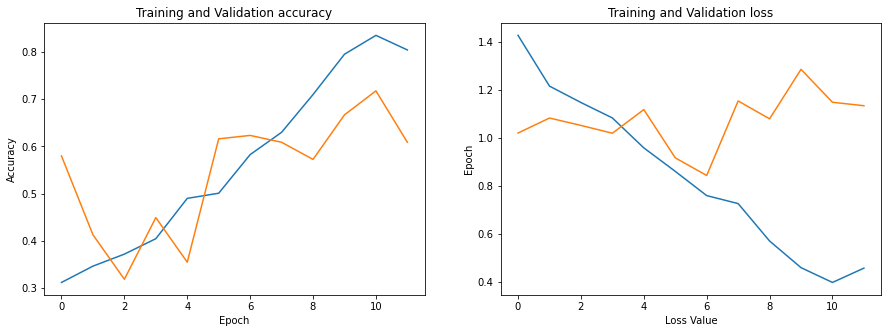

<-------- Fold : 1 for  target : Hillary Clinton -------->
Epoch 1/50
18/18 [==============================] - 11s 585ms/step - loss: 0.9539 - accuracy: 0.5390 - val_loss: 0.9521 - val_accuracy: 0.6739
Epoch 2/50
18/18 [==============================] - 9s 495ms/step - loss: 0.8264 - accuracy: 0.6751 - val_loss: 0.7829 - val_accuracy: 0.6884
Epoch 3/50
18/18 [==============================] - 9s 491ms/step - loss: 0.9478 - accuracy: 0.6606 - val_loss: 0.7034 - val_accuracy: 0.7246
Epoch 4/50
18/18 [==============================] - 8s 446ms/step - loss: 0.7641 - accuracy: 0.5753 - val_loss: 0.9079 - val_accuracy: 0.6884
Epoch 5/50
18/18 [==============================] - 8s 447ms/step - loss: 0.6749 - accuracy: 0.6515 - val_loss: 0.8698 - val_accuracy: 0.5797
Epoch 6/50
18/18 [==============================] - 8s 448ms/step - loss: 0.8284 - accuracy: 0.5535 - val_loss: 1.4341 - val_accuracy: 0.5507
Epoch 7/50
18/18 [==============================] - 9s 494ms/step - loss: 0.8156 - accur

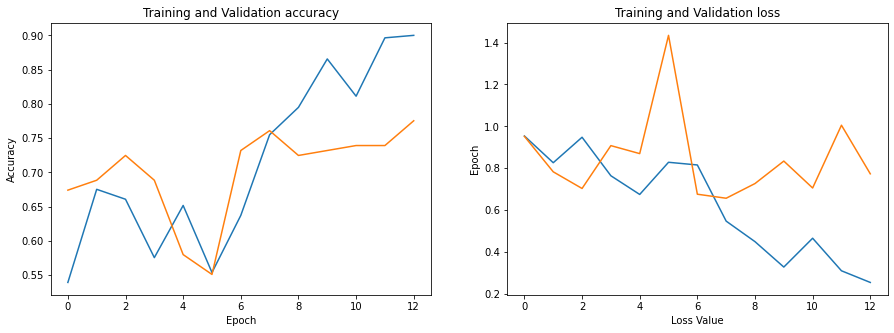

<-------- Fold : 2 for  target : Hillary Clinton -------->
Epoch 1/50
18/18 [==============================] - 10s 568ms/step - loss: 0.8409 - accuracy: 0.6515 - val_loss: 0.4544 - val_accuracy: 0.8478
Epoch 2/50
18/18 [==============================] - 9s 495ms/step - loss: 0.5428 - accuracy: 0.7623 - val_loss: 0.3056 - val_accuracy: 0.8913
Epoch 3/50
18/18 [==============================] - 8s 447ms/step - loss: 0.3916 - accuracy: 0.8494 - val_loss: 0.3624 - val_accuracy: 0.8696
Epoch 4/50
18/18 [==============================] - 8s 449ms/step - loss: 0.3919 - accuracy: 0.8711 - val_loss: 0.6096 - val_accuracy: 0.8261
Epoch 5/50
18/18 [==============================] - 8s 448ms/step - loss: 0.3653 - accuracy: 0.8730 - val_loss: 0.3344 - val_accuracy: 0.8841
Epoch 6/50
18/18 [==============================] - 8s 447ms/step - loss: 0.2614 - accuracy: 0.9183 - val_loss: 0.3522 - val_accuracy: 0.9058
Epoch 7/50
5/5 [==============================] - 1s 103ms/step - loss: 0.3056 - accurac

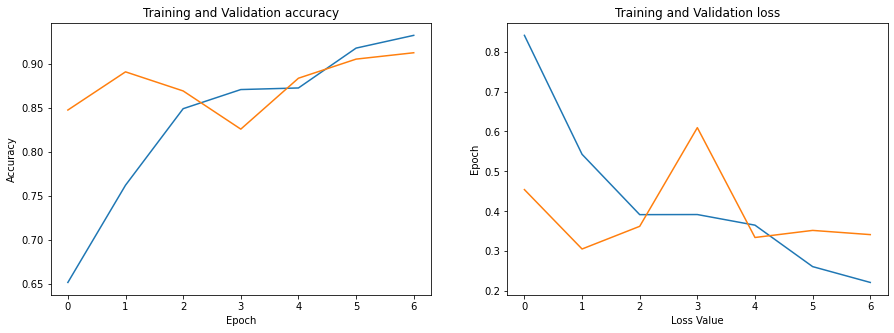

<-------- Fold : 3 for  target : Hillary Clinton -------->
Epoch 1/50
18/18 [==============================] - 10s 573ms/step - loss: 0.7404 - accuracy: 0.6679 - val_loss: 0.4323 - val_accuracy: 0.8261
Epoch 2/50
18/18 [==============================] - 9s 504ms/step - loss: 0.5348 - accuracy: 0.8240 - val_loss: 0.3551 - val_accuracy: 0.8551
Epoch 3/50
18/18 [==============================] - 8s 448ms/step - loss: 0.3210 - accuracy: 0.8875 - val_loss: 0.4205 - val_accuracy: 0.8623
Epoch 4/50
18/18 [==============================] - 8s 446ms/step - loss: 0.2841 - accuracy: 0.9074 - val_loss: 0.5769 - val_accuracy: 0.8333
Epoch 5/50
18/18 [==============================] - 8s 448ms/step - loss: 0.2753 - accuracy: 0.9111 - val_loss: 0.4189 - val_accuracy: 0.8623
Epoch 6/50
18/18 [==============================] - 9s 490ms/step - loss: 0.2957 - accuracy: 0.9038 - val_loss: 0.3129 - val_accuracy: 0.8841
Epoch 7/50
18/18 [==============================] - 8s 447ms/step - loss: 0.1960 - accur

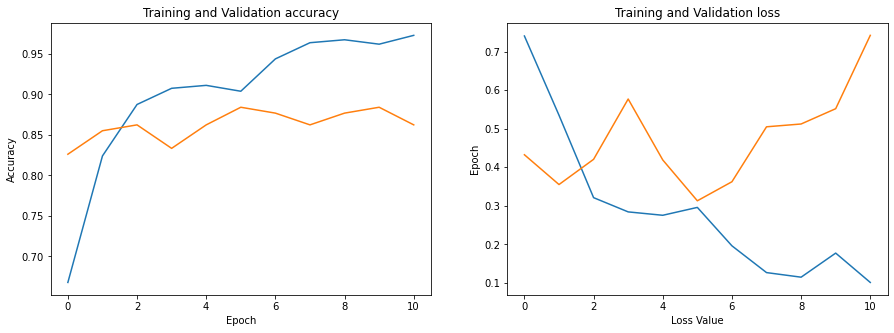

<-------- Fold : 4 for  target : Hillary Clinton -------->
Epoch 1/50
18/18 [==============================] - 10s 573ms/step - loss: 0.6603 - accuracy: 0.7663 - val_loss: 0.1033 - val_accuracy: 0.9781
Epoch 2/50
18/18 [==============================] - 8s 451ms/step - loss: 0.3585 - accuracy: 0.9058 - val_loss: 0.1249 - val_accuracy: 0.9416
Epoch 3/50
18/18 [==============================] - 9s 494ms/step - loss: 0.2264 - accuracy: 0.9330 - val_loss: 0.1017 - val_accuracy: 0.9781
Epoch 4/50
18/18 [==============================] - 8s 447ms/step - loss: 0.2893 - accuracy: 0.9257 - val_loss: 0.1023 - val_accuracy: 0.9635
Epoch 5/50
18/18 [==============================] - 8s 447ms/step - loss: 0.1673 - accuracy: 0.9493 - val_loss: 0.1441 - val_accuracy: 0.9635
Epoch 6/50
18/18 [==============================] - 8s 448ms/step - loss: 0.1496 - accuracy: 0.9656 - val_loss: 0.3400 - val_accuracy: 0.9489
Epoch 7/50
18/18 [==============================] - 8s 446ms/step - loss: 0.1828 - accur

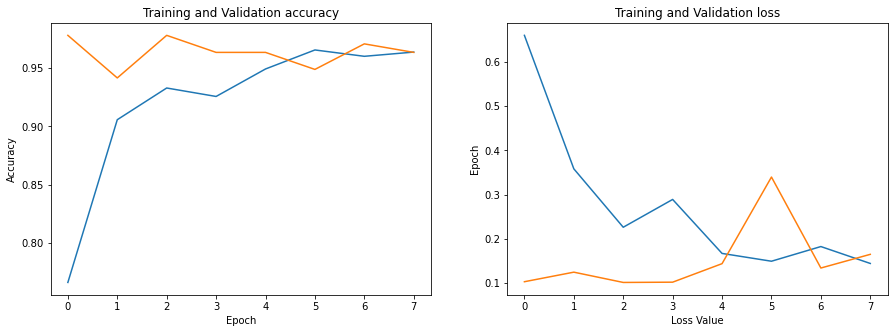

--------------------------------------------------
Average accuracy across all 5 folds : 82.75% (+/- 12.34%)


In [38]:
y = encode_labels(hc_df['Stance'], le)
train_model(hc_df['Target'].unique()[0], hc_df['Tweet'], y, batch_size = 32, learning_rate = 2e-5)

### Training Model for Legalization of Abortion

<-------- Fold : 0 for  target : Legalization of Abortion -------->
Epoch 1/50
17/17 [==============================] - 10s 579ms/step - loss: 1.4134 - accuracy: 0.3812 - val_loss: 1.1505 - val_accuracy: 0.1985
Epoch 2/50
17/17 [==============================] - 8s 490ms/step - loss: 1.2044 - accuracy: 0.3793 - val_loss: 1.1023 - val_accuracy: 0.2672
Epoch 3/50
17/17 [==============================] - 8s 446ms/step - loss: 1.1627 - accuracy: 0.3659 - val_loss: 1.1274 - val_accuracy: 0.1908
Epoch 4/50
17/17 [==============================] - 8s 446ms/step - loss: 1.1441 - accuracy: 0.3506 - val_loss: 1.1101 - val_accuracy: 0.2748
Epoch 5/50
17/17 [==============================] - 8s 498ms/step - loss: 1.1182 - accuracy: 0.3697 - val_loss: 1.0981 - val_accuracy: 0.2672
Epoch 6/50
17/17 [==============================] - 8s 489ms/step - loss: 1.1171 - accuracy: 0.4061 - val_loss: 1.0686 - val_accuracy: 0.5267
Epoch 7/50
17/17 [==============================] - 8s 447ms/step - loss: 1.101

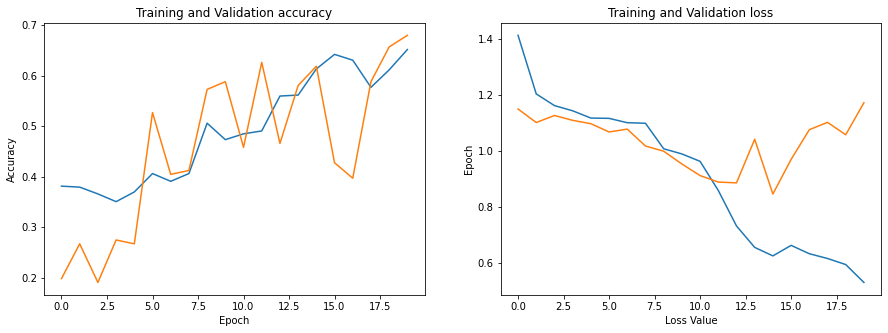

<-------- Fold : 1 for  target : Legalization of Abortion -------->
Epoch 1/50
17/17 [==============================] - 10s 567ms/step - loss: 0.9468 - accuracy: 0.5019 - val_loss: 0.7464 - val_accuracy: 0.4427
Epoch 2/50
17/17 [==============================] - 8s 449ms/step - loss: 0.8180 - accuracy: 0.5441 - val_loss: 0.8969 - val_accuracy: 0.7176
Epoch 3/50
17/17 [==============================] - 8s 495ms/step - loss: 0.7618 - accuracy: 0.5766 - val_loss: 0.6099 - val_accuracy: 0.8321
Epoch 4/50
17/17 [==============================] - 8s 450ms/step - loss: 0.6344 - accuracy: 0.6533 - val_loss: 0.6974 - val_accuracy: 0.6412
Epoch 5/50
17/17 [==============================] - 8s 446ms/step - loss: 0.5602 - accuracy: 0.7299 - val_loss: 0.7059 - val_accuracy: 0.6947
Epoch 6/50
17/17 [==============================] - 8s 448ms/step - loss: 0.4493 - accuracy: 0.7931 - val_loss: 0.6137 - val_accuracy: 0.7710
Epoch 7/50
17/17 [==============================] - 8s 446ms/step - loss: 0.365

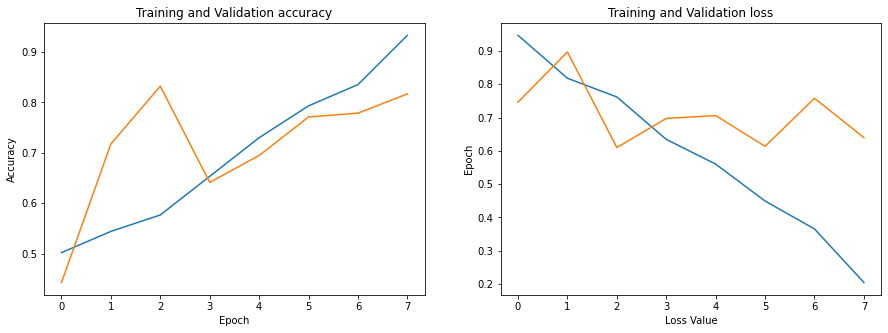

<-------- Fold : 2 for  target : Legalization of Abortion -------->
Epoch 1/50
17/17 [==============================] - 10s 573ms/step - loss: 0.8853 - accuracy: 0.5249 - val_loss: 0.5529 - val_accuracy: 0.7099
Epoch 2/50
17/17 [==============================] - 8s 448ms/step - loss: 0.7118 - accuracy: 0.6379 - val_loss: 0.6194 - val_accuracy: 0.7328
Epoch 3/50
17/17 [==============================] - 8s 446ms/step - loss: 0.6034 - accuracy: 0.6858 - val_loss: 0.5681 - val_accuracy: 0.7176
Epoch 4/50
17/17 [==============================] - 8s 447ms/step - loss: 0.4023 - accuracy: 0.8180 - val_loss: 0.8215 - val_accuracy: 0.7557
Epoch 5/50
17/17 [==============================] - 8s 446ms/step - loss: 0.2701 - accuracy: 0.9310 - val_loss: 0.8519 - val_accuracy: 0.7710
Epoch 6/50
5/5 [==============================] - 0s 96ms/step - loss: 0.5529 - accuracy: 0.7099
--------------------------------------------------
Training accuaray for fold 2 :  0.7126436829566956
Validation accuracy fo

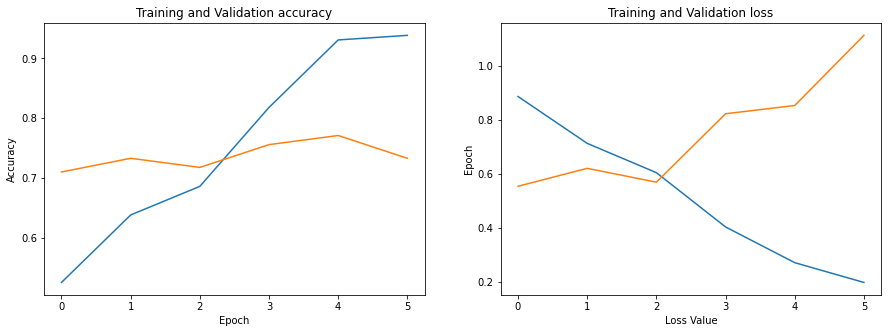

<-------- Fold : 3 for  target : Legalization of Abortion -------->
Epoch 1/50
17/17 [==============================] - 10s 580ms/step - loss: 0.9003 - accuracy: 0.5545 - val_loss: 0.6422 - val_accuracy: 0.5769
Epoch 2/50
17/17 [==============================] - 8s 448ms/step - loss: 0.6707 - accuracy: 0.6558 - val_loss: 0.6619 - val_accuracy: 0.6308
Epoch 3/50
17/17 [==============================] - 9s 503ms/step - loss: 0.5575 - accuracy: 0.6692 - val_loss: 0.4682 - val_accuracy: 0.8462
Epoch 4/50
17/17 [==============================] - 8s 491ms/step - loss: 0.3918 - accuracy: 0.8241 - val_loss: 0.3100 - val_accuracy: 0.8923
Epoch 5/50
17/17 [==============================] - 8s 487ms/step - loss: 0.2795 - accuracy: 0.8719 - val_loss: 0.3086 - val_accuracy: 0.8846
Epoch 6/50
17/17 [==============================] - 8s 450ms/step - loss: 0.1924 - accuracy: 0.9331 - val_loss: 1.1926 - val_accuracy: 0.7692
Epoch 7/50
17/17 [==============================] - 8s 449ms/step - loss: 0.201

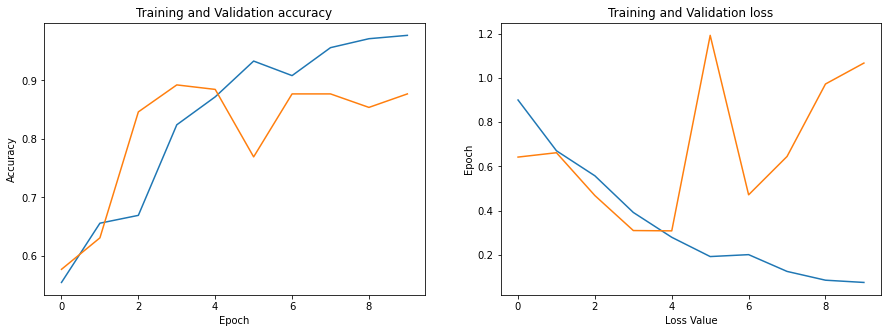

<-------- Fold : 4 for  target : Legalization of Abortion -------->
Epoch 1/50
17/17 [==============================] - 10s 585ms/step - loss: 0.6735 - accuracy: 0.7094 - val_loss: 0.1733 - val_accuracy: 0.9538
Epoch 2/50
17/17 [==============================] - 8s 447ms/step - loss: 0.3733 - accuracy: 0.8662 - val_loss: 0.1884 - val_accuracy: 0.9385
Epoch 3/50
17/17 [==============================] - 8s 446ms/step - loss: 0.3038 - accuracy: 0.9159 - val_loss: 0.5931 - val_accuracy: 0.8462
Epoch 4/50
17/17 [==============================] - 8s 446ms/step - loss: 0.2968 - accuracy: 0.9216 - val_loss: 0.2305 - val_accuracy: 0.9308
Epoch 5/50
17/17 [==============================] - 8s 446ms/step - loss: 0.1414 - accuracy: 0.9637 - val_loss: 0.3182 - val_accuracy: 0.9385
Epoch 6/50
5/5 [==============================] - 0s 96ms/step - loss: 0.1733 - accuracy: 0.9538
--------------------------------------------------
Training accuaray for fold 4 :  0.9445506930351257
Validation accuracy fo

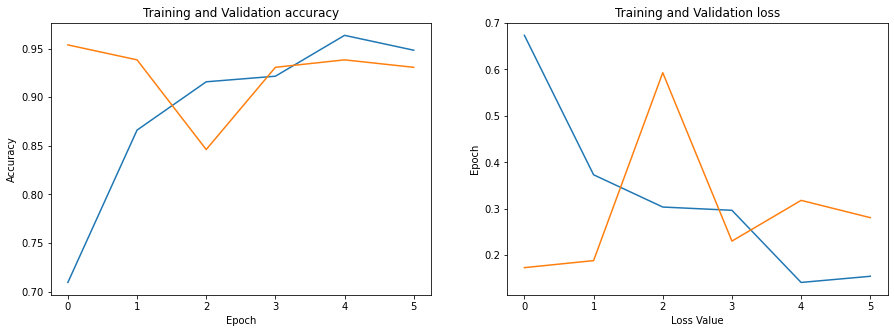

--------------------------------------------------
Average accuracy across all 5 folds : 79.98% (+/- 12.08%)


In [41]:
y = encode_labels(la_df['Stance'], le)
train_model(la_df['Target'].unique()[0], la_df['Tweet'], y, batch_size = 32, learning_rate = 2e-5)

### Training Model for Target Donald Trump

In [49]:
dt_train = train_df[train_df['Target'] != 'Hillary Clinton']
dt_val = train_df[train_df['Target'] == 'Hillary Clinton']

In [50]:
def train_model_donald_trump(X_train, y_train, X_val, y_val, batch_size, learning_rate):  
  
    # Performing Bert tokenization and then padding to train and validation tweets
    train_x = bert_tokenizer_and_padding(X_train, tokenizer)
    val_x = bert_tokenizer_and_padding(X_val, tokenizer)
    
    # Converting our label encoded class vector to binary class vector
    y_class = y_train
    train_y = to_categorical(y_train, dtype ="uint8")
    val_y = to_categorical(y_val, dtype ="uint8")

    # Building our model
    model = build_model(bert_layer)
    
    # Configuring our model for training by using Adam optimizer and categorical crossentropy loss
    model.compile(keras.optimizers.Adam(lr = learning_rate), loss = 'categorical_crossentropy', metrics = ['accuracy'])

    #Estimating our class weight for imbalance classes
    class_weights = class_weight.compute_class_weight('balanced', np.unique(y_class), y_class)
    class_weight_dict = dict(enumerate(class_weights))
    
    # Using Model checkpoint to save best weight for our Model
    # model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    # filepath=model_paths + target +'.h5',
    # monitor='loss',
    # mode='min',
    # save_best_only=True)

    # Using EarlyStopping to stop and restore to best weight if model validaiton loss does not improve straight for 5 epochs
    early_stopping_call = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, mode = 'min', min_delta = 0.001, restore_best_weights = True)

    
    # Training our Model
    history = model.fit(
      x = train_x, 
      y = train_y,
      batch_size = batch_size,
      class_weight = class_weight_dict,
      validation_data = (val_x, val_y),
      epochs = 50,
      callbacks = [early_stopping_call])
    
    return model, history

In [51]:
y_train = encode_labels(dt_train['Stance'], le)
y_val = encode_labels(dt_val['Stance'], le)
model, history = train_model_donald_trump(dt_train['Tweet'], y_train, dt_val['Tweet'], y_val, 16, 2e-6)

Epoch 1/50
140/140 [==============================] - 41s 295ms/step - loss: 1.3772 - accuracy: 0.3658 - val_loss: 1.1946 - val_accuracy: 0.1727
Epoch 2/50
140/140 [==============================] - 40s 287ms/step - loss: 1.1801 - accuracy: 0.3685 - val_loss: 1.1258 - val_accuracy: 0.2322
Epoch 3/50
140/140 [==============================] - 38s 274ms/step - loss: 1.1486 - accuracy: 0.3524 - val_loss: 1.1392 - val_accuracy: 0.2104
Epoch 4/50
140/140 [==============================] - 39s 280ms/step - loss: 1.1263 - accuracy: 0.3789 - val_loss: 1.1245 - val_accuracy: 0.2163
Epoch 5/50
140/140 [==============================] - 38s 274ms/step - loss: 1.1016 - accuracy: 0.3870 - val_loss: 1.1335 - val_accuracy: 0.2351
Epoch 6/50
140/140 [==============================] - 39s 280ms/step - loss: 1.0726 - accuracy: 0.4117 - val_loss: 1.1226 - val_accuracy: 0.2859
Epoch 7/50
140/140 [==============================] - 38s 274ms/step - loss: 1.0371 - accuracy: 0.4629 - val_loss: 1.1782 - val_ac

## Training model on all example for individual targets in training data using tuned hyper parameters

#### Function to train the model on whole dataset

In [64]:
def train_model_without_cv(target, X, y, batch_size, learning_rate, epochs):  
  
    # Performing Bert tokenization and then padding to train and validatio tweets
    train_x = bert_tokenizer_and_padding(X, tokenizer)
    
    # Converting our label encoded class vector to binary class vector
    y_class = y
    train_y = to_categorical(y, dtype ="uint8")

    # Building our model
    model = build_model(bert_layer)
    
    # Configuring our model for training by using Adam optimizer and categorical crossentropy loss
    model.compile(keras.optimizers.Adam(lr = learning_rate), loss = 'categorical_crossentropy', metrics = ['accuracy'])

    #Estimating our class weight for imbalance classes
    class_weights = class_weight.compute_class_weight('balanced', np.unique(y_class), y_class)
    class_weight_dict = dict(enumerate(class_weights))

    # Using EarlyStopping to stop and restore to best weight if model validaiton loss does not improve straight for 5 epochs
    early_stopping_call = keras.callbacks.EarlyStopping(monitor = 'loss', patience = 5, mode = 'min', min_delta = 0.001, restore_best_weights = True)

    
    # Training our Model
    history = model.fit(
      x = train_x, 
      y = train_y,
      batch_size = batch_size,
      class_weight = class_weight_dict,
      epochs = epochs,
      callbacks = [early_stopping_call])
    
    return model, history

#### Training our model on all the targes in our training data

### Training model for Target "Athesim"

In [49]:
# Encoding label for given target 
y = encode_labels(aa_df['Stance'], le)

# Create output directory if it doesn't exist
model_paths = "Target_Models/"
os.makedirs(model_paths, exist_ok=True)

# After Hyper parameter tuning using cross validation and loss curve train the model on whole dataset
model, history = train_model_without_cv(aa_df['Target'].unique()[0], aa_df['Tweet'], y, 32, 2e-5, 15, model_paths)

# Saving model to output directory
model.save(model_paths + fm_df['Target'].unique()[0] + '.h5')

Epoch 1/15
17/17 [==============================] - 13s 742ms/step - loss: 0.6073 - accuracy: 0.7739
Epoch 2/15
17/17 [==============================] - 14s 823ms/step - loss: 0.1990 - accuracy: 0.9298
Epoch 3/15
17/17 [==============================] - 13s 754ms/step - loss: 0.1341 - accuracy: 0.9669
Epoch 4/15
17/17 [==============================] - 13s 757ms/step - loss: 0.0667 - accuracy: 0.9864
Epoch 5/15
17/17 [==============================] - 12s 713ms/step - loss: 0.1750 - accuracy: 0.9649
Epoch 6/15
17/17 [==============================] - 13s 776ms/step - loss: 0.0584 - accuracy: 0.9825
Epoch 7/15
17/17 [==============================] - 12s 726ms/step - loss: 0.0664 - accuracy: 0.9903
Epoch 8/15
17/17 [==============================] - 13s 783ms/step - loss: 0.0340 - accuracy: 0.9922
Epoch 9/15
17/17 [==============================] - 12s 724ms/step - loss: 0.0509 - accuracy: 0.9903
Epoch 10/15
17/17 [==============================] - 12s 720ms/step - loss: 0.1913 - accura

### Training Model for Target "Feminist Movement" 

In [40]:
# Encoding label for given target 
y = encode_labels(fm_df['Stance'], le)

# Create output directory if it doesn't exist
model_paths = "Target_Models/"
os.makedirs(model_paths, exist_ok=True)

# After Hyper parameter tuning using cross validation and loss curve train the model on whole dataset
model, history = train_model_without_cv(fm_df['Target'].unique()[0], fm_df['Tweet'], y, 32, 2e-6, 40)

# Saving model to output directory
model.save(model_paths + fm_df['Target'].unique()[0] + '.h5')

Epoch 1/40
21/21 [==============================] - 15s 735ms/step - loss: 1.4785 - accuracy: 0.3328
Epoch 2/40
21/21 [==============================] - 16s 779ms/step - loss: 1.3243 - accuracy: 0.3795
Epoch 3/40
21/21 [==============================] - 16s 755ms/step - loss: 1.2311 - accuracy: 0.4006
Epoch 4/40
21/21 [==============================] - 16s 758ms/step - loss: 1.1938 - accuracy: 0.3780
Epoch 5/40
21/21 [==============================] - 16s 766ms/step - loss: 1.1753 - accuracy: 0.4006
Epoch 6/40
21/21 [==============================] - 16s 771ms/step - loss: 1.0601 - accuracy: 0.4774
Epoch 7/40
21/21 [==============================] - 16s 771ms/step - loss: 1.0531 - accuracy: 0.4910
Epoch 8/40
21/21 [==============================] - 15s 725ms/step - loss: 1.0686 - accuracy: 0.4699
Epoch 9/40
21/21 [==============================] - 16s 776ms/step - loss: 1.0034 - accuracy: 0.4639
Epoch 10/40
21/21 [==============================] - 17s 809ms/step - loss: 0.9906 - accura

### Training Model for Target "Climate Change is a Real Concern"

In [43]:
y = encode_labels(cc_df['Stance'], le)

# After Hyper parameter tuning using cross validation and loss curve train the model on whole dataset
model_paths = "/content/drive/My Drive/Target_Models/"
os.makedirs(model_paths, exist_ok=True)

model, history = train_model_without_cv(cc_df['Target'].unique()[0], cc_df['Tweet'], y, 32, 2e-5, 10)

model.save(model_paths + cc_df['Target'].unique()[0] + '.h5')

Epoch 1/10
13/13 [==============================] - 10s 798ms/step - loss: 1.6327 - accuracy: 0.4380
Epoch 2/10
13/13 [==============================] - 11s 854ms/step - loss: 1.1597 - accuracy: 0.4734
Epoch 3/10
13/13 [==============================] - 11s 812ms/step - loss: 1.0367 - accuracy: 0.5392
Epoch 4/10
13/13 [==============================] - 10s 783ms/step - loss: 0.8262 - accuracy: 0.6051
Epoch 5/10
13/13 [==============================] - 10s 776ms/step - loss: 0.7229 - accuracy: 0.6506
Epoch 6/10
13/13 [==============================] - 10s 771ms/step - loss: 0.6445 - accuracy: 0.7316
Epoch 7/10
13/13 [==============================] - 10s 779ms/step - loss: 0.5661 - accuracy: 0.7747
Epoch 8/10
13/13 [==============================] - 10s 787ms/step - loss: 0.4614 - accuracy: 0.8025
Epoch 9/10
13/13 [==============================] - 9s 717ms/step - loss: 0.4938 - accuracy: 0.8127
Epoch 10/10
13/13 [==============================] - 10s 792ms/step - loss: 0.2231 - accurac

### Training model for Target "Hillary Clinton"

In [64]:
# Encoding label for given target 
y = encode_labels(hc_df['Stance'], le)

del model
# Create output directory if it doesn't exist
model_paths = "Target_Models/"
os.makedirs(model_paths, exist_ok=True)

# After Hyper parameter tuning using cross validation and loss curve train the model on whole dataset
model, history = train_model_without_cv(hc_df['Target'].unique()[0], hc_df['Tweet'], y, 32, 2e-5, 18)

# Saving model to output directory
model.save(model_paths + hc_df['Target'].unique()[0] + '.h5')

Epoch 1/18
22/22 [==============================] - 17s 768ms/step - loss: 0.6668 - accuracy: 0.7039
Epoch 2/18
22/22 [==============================] - 18s 818ms/step - loss: 0.2201 - accuracy: 0.9100
Epoch 3/18
22/22 [==============================] - 18s 832ms/step - loss: 0.1813 - accuracy: 0.9434
Epoch 4/18
22/22 [==============================] - 18s 821ms/step - loss: 0.1128 - accuracy: 0.9782
Epoch 5/18
22/22 [==============================] - 16s 743ms/step - loss: 0.1616 - accuracy: 0.9594
Epoch 6/18
22/22 [==============================] - 16s 740ms/step - loss: 0.1139 - accuracy: 0.9666
Epoch 7/18
22/22 [==============================] - 18s 802ms/step - loss: 0.0925 - accuracy: 0.9739
Epoch 8/18
22/22 [==============================] - 18s 800ms/step - loss: 0.0914 - accuracy: 0.9739
Epoch 9/18
22/22 [==============================] - 17s 794ms/step - loss: 0.0622 - accuracy: 0.9840
Epoch 10/18
22/22 [==============================] - 16s 746ms/step - loss: 0.0618 - accura

### Training model for Target "Legalization of Abortion"

In [35]:
# Encoding label for given target 
y = encode_labels(la_df['Stance'], le)

del model
# Create output directory if it doesn't exist
model_paths = "/content/drive/My Drive/Target_Models/"
os.makedirs(model_paths, exist_ok=True)

# After Hyper parameter tuning using cross validation and loss curve train the model on whole dataset
model, history = train_model_without_cv(la_df['Target'].unique()[0], la_df['Tweet'], y, 32, 2e-5, 20)

# Saving model to output directory
model.save(model_paths + la_df['Target'].unique()[0] + '.h5')

Epoch 1/20
21/21 [==============================] - 16s 782ms/step - loss: 1.2715 - accuracy: 0.3783
Epoch 2/20
21/21 [==============================] - 18s 847ms/step - loss: 1.1576 - accuracy: 0.3583
Epoch 3/20
21/21 [==============================] - 17s 810ms/step - loss: 1.1021 - accuracy: 0.3828
Epoch 4/20
21/21 [==============================] - 16s 781ms/step - loss: 1.0468 - accuracy: 0.4472
Epoch 5/20
21/21 [==============================] - 16s 777ms/step - loss: 0.9190 - accuracy: 0.5268
Epoch 6/20
21/21 [==============================] - 17s 790ms/step - loss: 0.7398 - accuracy: 0.6524
Epoch 7/20
21/21 [==============================] - 17s 803ms/step - loss: 0.6016 - accuracy: 0.7213
Epoch 8/20
21/21 [==============================] - 17s 798ms/step - loss: 0.4679 - accuracy: 0.8055
Epoch 9/20
21/21 [==============================] - 17s 790ms/step - loss: 0.3201 - accuracy: 0.8744
Epoch 10/20
21/21 [==============================] - 17s 793ms/step - loss: 0.2264 - accura

### Training Model for Target Donald Trump**

In [49]:
dt_train = train_df[train_df['Target'] != 'Hillary Clinton']
dt_val = train_df[train_df['Target'] == 'Hillary Clinton']

In [50]:
def train_model_donald_trump(X_train, y_train, X_val, y_val, batch_size, learning_rate):  
  
    # Performing Bert tokenization and then padding to train and validation tweets
    train_x = bert_tokenizer_and_padding(X_train, tokenizer)
    val_x = bert_tokenizer_and_padding(X_val, tokenizer)
    
    # Converting our label encoded class vector to binary class vector
    y_class = y_train
    train_y = to_categorical(y_train, dtype ="uint8")
    val_y = to_categorical(y_val, dtype ="uint8")

    # Building our model
    model = build_model(bert_layer)
    
    # Configuring our model for training by using Adam optimizer and categorical crossentropy loss
    model.compile(keras.optimizers.Adam(lr = learning_rate), loss = 'categorical_crossentropy', metrics = ['accuracy'])

    #Estimating our class weight for imbalance classes
    class_weights = class_weight.compute_class_weight('balanced', np.unique(y_class), y_class)
    class_weight_dict = dict(enumerate(class_weights))
    
    # Using Model checkpoint to save best weight for our Model
    # model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    # filepath=model_paths + target +'.h5',
    # monitor='loss',
    # mode='min',
    # save_best_only=True)

    # Using EarlyStopping to stop and restore to best weight if model validaiton loss does not improve straight for 5 epochs
    early_stopping_call = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, mode = 'min', min_delta = 0.001, restore_best_weights = True)

    
    # Training our Model
    history = model.fit(
      x = train_x, 
      y = train_y,
      batch_size = batch_size,
      class_weight = class_weight_dict,
      validation_data = (val_x, val_y),
      epochs = 50,
      callbacks = [early_stopping_call])
    
    return model, history

In [48]:
y = encode_labels(train_df['Stance'], le)

model_dt, history_dt = train_model_without_cv("Donald Trump", train_df['Tweet'], y, 16, 2e-6, 20)

Epoch 1/20
183/183 [==============================] - 47s 258ms/step - loss: 1.4767 - accuracy: 0.3339
Epoch 2/20
183/183 [==============================] - 48s 263ms/step - loss: 1.2406 - accuracy: 0.3603
Epoch 3/20
183/183 [==============================] - 47s 257ms/step - loss: 1.1578 - accuracy: 0.3809
Epoch 4/20
183/183 [==============================] - 47s 256ms/step - loss: 1.1344 - accuracy: 0.3720
Epoch 5/20
183/183 [==============================] - 47s 256ms/step - loss: 1.1208 - accuracy: 0.3868
Epoch 6/20
183/183 [==============================] - 47s 256ms/step - loss: 1.1014 - accuracy: 0.4019
Epoch 7/20
183/183 [==============================] - 46s 252ms/step - loss: 1.1008 - accuracy: 0.3895
Epoch 8/20
183/183 [==============================] - 47s 255ms/step - loss: 1.0909 - accuracy: 0.4146
Epoch 9/20
183/183 [==============================] - 47s 256ms/step - loss: 1.0766 - accuracy: 0.4272
Epoch 10/20
183/183 [==============================] - 47s 255ms/step - l

## Testing our model performance on Test Data

#### Performing Text PreProcessing on our test data and creating separate dataframe from each individual taget in our test data

In [60]:
# Cleaing all the tweets in test data
test_df['Tweet'] = test_df['Tweet'].apply(str).apply(lambda x: clean_text.all_preprocessing(x))

# Separating tweets into different dataframe for every target in test data
hc_test = test_df[test_df['Target'] == 'Hillary Clinton']
aa_test = test_df[test_df['Target'] == 'Atheism']
la_test = test_df[test_df['Target'] == 'Legalization of Abortion']
fm_test = test_df[test_df['Target'] == 'Feminist Movement']
cc_test = test_df[test_df['Target'] == 'Climate Change is a Real Concern']
dt_test =  test_df[test_df['Target'] == 'Donald Trump']

#### Function to predict model result and then printing classification report and performace matrix

In [61]:
def test_result(model, test_df):
    # Tokenize and Pad test data
    test_x = bert_tokenizer_and_padding(test_df['Tweet'], tokenizer)
    test_y = encode_labels(test_df['Stance'], le)
    
    # Predicting on test data
    y_pred = model.predict(test_x)
    
    y = []
    for pred in y_pred:
        y.append(np.argmax(pred))
    
    y_pred =  le.inverse_transform(y)
    cm = confusion_matrix(test_df['Stance'], y_pred)
    cm = cm.astype('int')
    
    # Print confusion matrix
    print (cm)

    labels = le.classes_
    
    # Printing classificaiton report for macro f1 score
    print(classification_report(test_df['Stance'], y_pred, target_names=labels))

### TRAINED MODEL Performance for target "Atheism" on Test Data

In [44]:
model = keras.models.load_model(model_paths + aa_df['Target'].unique()[0] + '.h5', custom_objects={'KerasLayer':hub.KerasLayer})
test_result(model, aa_test)

[[127  21  12]
 [  6  25   1]
 [  5   1  22]]
              precision    recall  f1-score   support

     AGAINST       0.92      0.79      0.85       160
       FAVOR       0.53      0.78      0.63        32
        NONE       0.63      0.79      0.70        28

    accuracy                           0.79       220
   macro avg       0.69      0.79      0.73       220
weighted avg       0.83      0.79      0.80       220



### TRAINED MODEL Performance for target "Feminist Movement" on Test Data

In [41]:
model = keras.models.load_model(model_paths+ fm_df['Target'].unique()[0] + '.h5', custom_objects={'KerasLayer':hub.KerasLayer})
test_result(model, fm_test)

[[98 65 20]
 [17 40  1]
 [10  8 26]]
              precision    recall  f1-score   support

     AGAINST       0.78      0.54      0.64       183
       FAVOR       0.35      0.69      0.47        58
        NONE       0.55      0.59      0.57        44

    accuracy                           0.58       285
   macro avg       0.56      0.61      0.56       285
weighted avg       0.66      0.58      0.59       285



### TRAINED MODEL Performance for target "Climate Change is a Real Concern" on Test Data

In [24]:
model = keras.models.load_model(model_paths+ cc_df['Target'].unique()[0] + '.h5', custom_objects={'KerasLayer':hub.KerasLayer})
test_result(model, cc_test)

[[  0  10   1]
 [  0 118   5]
 [  0  33   2]]
              precision    recall  f1-score   support

     AGAINST       0.00      0.00      0.00        11
       FAVOR       0.73      0.96      0.83       123
        NONE       0.25      0.06      0.09        35

    accuracy                           0.71       169
   macro avg       0.33      0.34      0.31       169
weighted avg       0.59      0.71      0.62       169



### TRAINED MODEL Performance for target "Hillary Clinton" on Test Data

In [66]:
model = keras.models.load_model(model_paths+ hc_df['Target'].unique()[0] + '.h5', custom_objects={'KerasLayer':hub.KerasLayer})
test_result(model, hc_test)

[[144  11  17]
 [ 19  23   3]
 [ 35  10  33]]
              precision    recall  f1-score   support

     AGAINST       0.73      0.84      0.78       172
       FAVOR       0.52      0.51      0.52        45
        NONE       0.62      0.42      0.50        78

    accuracy                           0.68       295
   macro avg       0.62      0.59      0.60       295
weighted avg       0.67      0.68      0.67       295



### TRAINED MODEL Performance for target "Legalization of Abortion" on Test Data**

In [39]:
model = keras.models.load_model(model_paths+ hc_df['Target'].unique()[0] + '.h5', custom_objects={'KerasLayer':hub.KerasLayer})
test_result(model, la_test)

[[128  27  34]
 [ 12  32   2]
 [  8   6  31]]
              precision    recall  f1-score   support

     AGAINST       0.86      0.68      0.76       189
       FAVOR       0.49      0.70      0.58        46
        NONE       0.46      0.69      0.55        45

    accuracy                           0.68       280
   macro avg       0.61      0.69      0.63       280
weighted avg       0.74      0.68      0.70       280



### TRAINED MODEL Performance for target "Donald Trump" on Test Data

In [52]:
test_result(model_dt, dt_test)

[[105  29 165]
 [ 33  33  82]
 [ 78  25 157]]
              precision    recall  f1-score   support

     AGAINST       0.49      0.35      0.41       299
       FAVOR       0.38      0.22      0.28       148
        NONE       0.39      0.60      0.47       260

    accuracy                           0.42       707
   macro avg       0.42      0.39      0.39       707
weighted avg       0.43      0.42      0.41       707



## TESTING OUR MODEL PERFORMANCE ON REAL WORLD TWEETS EXTRACTED FROM TWITTER

In [ ]:
# Reading Independent Evaluation containing data for evaluation
ind_df = pd.read_csv('Independ_Evaluation.csv')
ind_df['Stance'] = ind_df['Stance'].str.upper() 

In [ ]:
# Cleaing all the tweets for independent data evaluation
ind_df['Tweet'] = ind_df['Tweet'].apply(str).apply(lambda x: clean_text.all_preprocessing(x))

# Separating tweets into different dataframe for every target
hc_ind = ind_df[ind_df['Target'] == 'Hillary Clinton']
aa_ind = ind_df[ind_df['Target'] == 'Atheism']
la_ind = ind_df[ind_df['Target'] == 'Legalization of Abortion']
fm_ind = ind_df[ind_df['Target'] == 'Feminist Movement']
cc_ind = ind_df[ind_df['Target'] == 'Climate Change is a Real Concern']

In [43]:
# Atheism
model_aa = keras.models.load_model('Target_Models/Atheism.h5', custom_objects={'KerasLayer':hub.KerasLayer})
test_result(model_aa, aa_ind)

[[0 1 0]
 [0 6 0]
 [1 1 0]]
              precision    recall  f1-score   support

     AGAINST       0.00      0.00      0.00         1
       FAVOR       0.75      1.00      0.86         6
        NONE       0.00      0.00      0.00         2

    accuracy                           0.67         9
   macro avg       0.25      0.33      0.29         9
weighted avg       0.50      0.67      0.57         9



In [44]:
# Hillary Clinton
model_hc = keras.models.load_model('Target_Models/Hillary Clinton.h5', custom_objects={'KerasLayer':hub.KerasLayer})
test_result(model_hc, hc_ind)

[[7 0 0]
 [0 4 0]
 [2 0 0]]
              precision    recall  f1-score   support

     AGAINST       0.78      1.00      0.88         7
       FAVOR       1.00      1.00      1.00         4
        NONE       0.00      0.00      0.00         2

    accuracy                           0.85        13
   macro avg       0.59      0.67      0.62        13
weighted avg       0.73      0.85      0.78        13



In [44]:
# Feminist Movement
model_fm = keras.models.load_model('Target_Models/Feminist Movement.h5', custom_objects={'KerasLayer':hub.KerasLayer})
test_result(model_fm, fm_ind)

[[1 1 0]
 [1 4 0]
 [0 2 0]]
              precision    recall  f1-score   support

     AGAINST       0.50      0.50      0.50         2
       FAVOR       0.57      0.80      0.67         5
        NONE       0.00      0.00      0.00         2

    accuracy                           0.56         9
   macro avg       0.36      0.43      0.39         9
weighted avg       0.43      0.56      0.48         9

